# LED Data: Oct 31, 2022
## Import the libraries

In [1]:
import sys,os
import time 
import h5py

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

import scipy
import scipy.optimize as opt
# import scipy.signal as sig
from scipy.interpolate import interp1d
from scipy.signal import periodogram,get_window,coherence,welch,csd

import PyMKID_USRP_functions as PUf
import PyMKID_resolution_functions as Prf
import MB_equations as MBe
import MB_analysis as MBa
import TimestreamHelperFunctions as Thf

## Gather the files

In [2]:
datapath = '/data/USRP_Laser_Data'
series   = "20221031_093936"

sum_file, dly_file, vna_file, nse_files, led_files = Thf.GetFiles(series, 
                                                        base_path=datapath,
                                                        sep_noise_laser=True,
                                                        verbose=False)

## Load the summary file

In [3]:
md, charFs, charZs = Thf.UnpackSummary(sum_file, verbose=False)
rf_power = md['power']
# print(charFs)
# print(charZs)
print("RF Power at USRP:", rf_power, "dBm")

/home/nexus-admin/NEXUS_RF/AnalysisScripts/TimestreamHelperFunctions.py:107: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  l_dict[kk] = md[k][kk].value


RF Power at USRP: -30 dBm


### LED voltages
Determine how many LED timestream files there are and get an array of the LED voltages used for each.

In [4]:
voltages = np.array([])

for k in md.keys():
    if 'LaserScan_' in k:
        voltages = np.append(voltages, float(int(1000*md[k]['LEDvoltage'][0]))/1000.)

n_volts  = len(voltages)
n_runs   = len(led_files)
print(n_volts, n_runs, "<-- These should be the same")
print("Vmin = ",np.min(voltages), "V")
print("Vmax = ",np.max(voltages), "V")
print("Vstep = ",int((voltages[1]-voltages[0])*1e3), "mV")

102 102 <-- These should be the same
Vmin =  2.8 V
Vmax =  4.82 V
Vstep =  20 mV


### Define some PSD parameters

In [5]:
## PSD hi and lo frequency limits
chunk_up_to      = 1e2
decimate_down_to = 5e4

## Transient period at front of timestream
blank_fraction = 0.2

### Extract the pulse profile
This assumes that each laser timestream is acquired with the same AWG settings.

In [6]:
LED_rate_Hz = 0 # 100.0
lapse_sec   = 0 # 10.0

## Extract the pulse settings, assuming they're all the same
for k in md.keys():
    if 'LaserScan_' in k:
        LED_rate_Hz = md[k]['LEDfreqHz'][0]
        lapse_sec   = md[k]['duration'][0]
#         pulse_w     = md[k]['pw_us'][0]
        break
LED_rate_Hz = LED_rate_Hz   #*5
print("Pulse f: ",LED_rate_Hz,"Hz")
# print("Pls wdth:",)
print("Duration:",lapse_sec,"sec")

total_pulses = LED_rate_Hz*lapse_sec

time_btw_pulse = 1./LED_rate_Hz
num_pulses = int(total_pulses * (1 - blank_fraction))
print("Total pulse windows:",total_pulses)
print("Time between pulse arrival:",time_btw_pulse,"sec")
print("Number of windows to look at:",num_pulses)

Pulse f:  100.0 Hz
Duration: 10.0 sec
Total pulse windows: 1000.0
Time between pulse arrival: 0.01 sec
Number of windows to look at: 800


## Noise cleaning to get cleaning coefficients

Will separate data into  1000 chunks to achieve the requested 1.00e+02  Hz low  end of the PSD
Additional decimation by 20 needed to achieve the requested 5.00e+04  Hz high end of the PSD
Will convert to resonator basis!
doing additional decimation
sampling frequency plugged into welch is 50000
pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Laser_Data/20221031/20221031_093936/USRP_Noise_20221031_093936_delta0.h5 because override=True!
found 6 pulses
chunk length plugged into welch is 500
chunked data into 1000 timestreams
computed electronics basis
cleaning...
(2, 397000)
(1, 397000)
(1, 397000)
(2, 397000)
(1, 397000)
(1, 397000)
saving clean_data to /data/USRP_Laser_Data/20221031/20221031_093936/USRP_Noise_20221031_093936_delta0_cleaned.h5 because override=True!
number of chunks used to average is 794
Converting to resonator basis!
Fr from fit  [GHz]: 4242.04996413815
Fr min curve [GHz]: 4242.049621393852
Fr from f

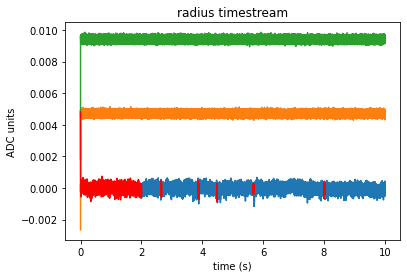

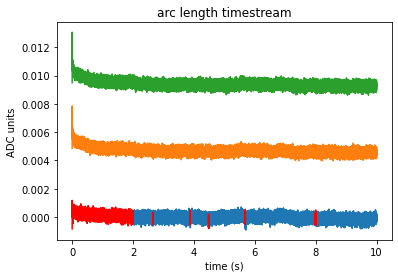

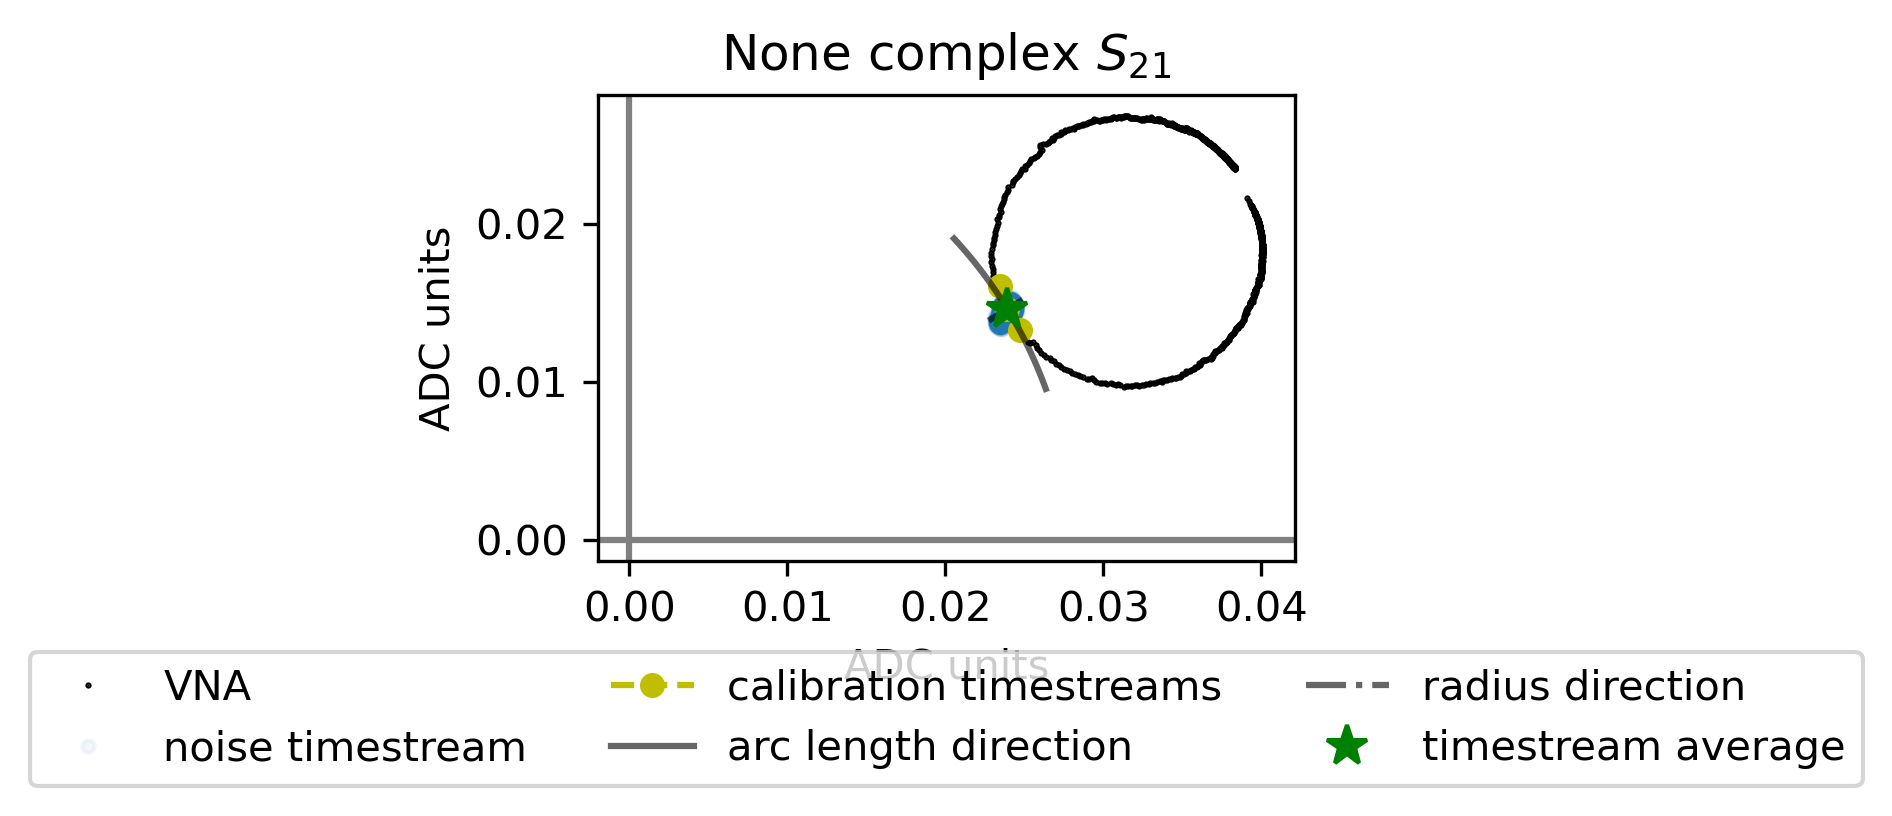

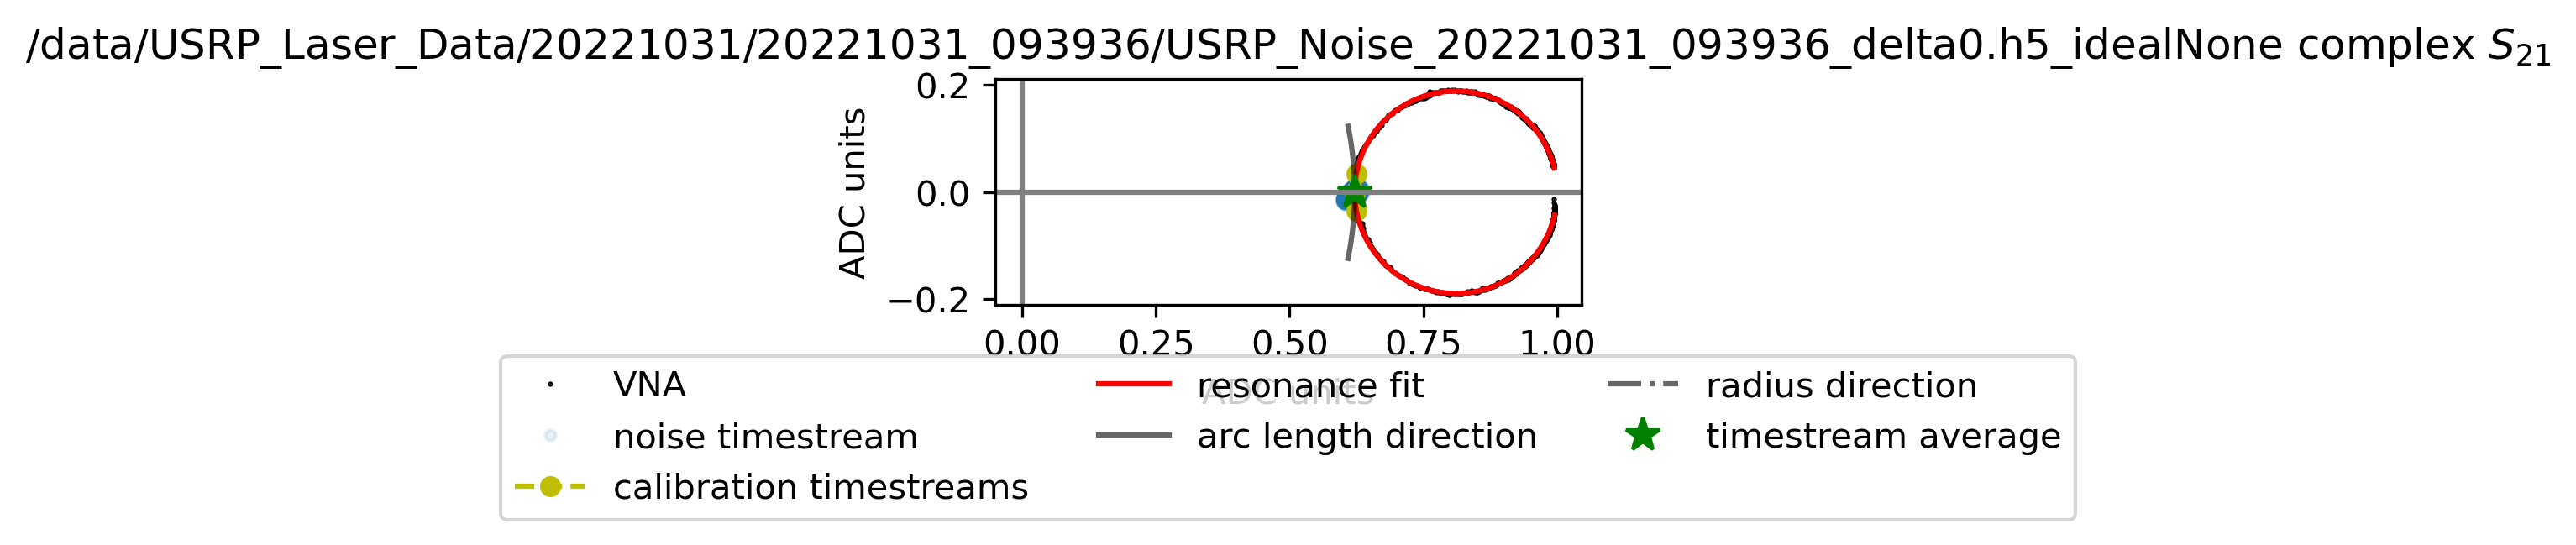

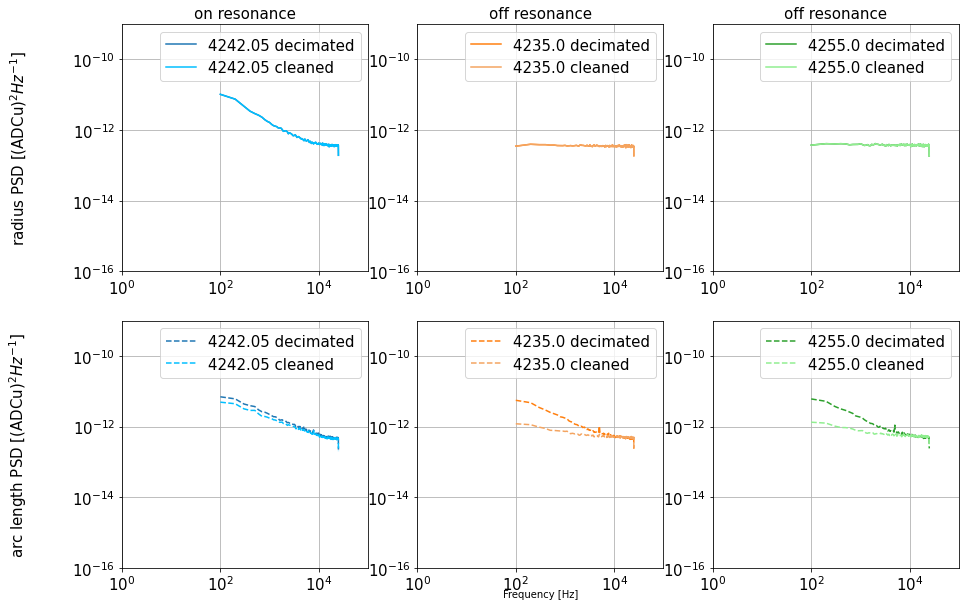

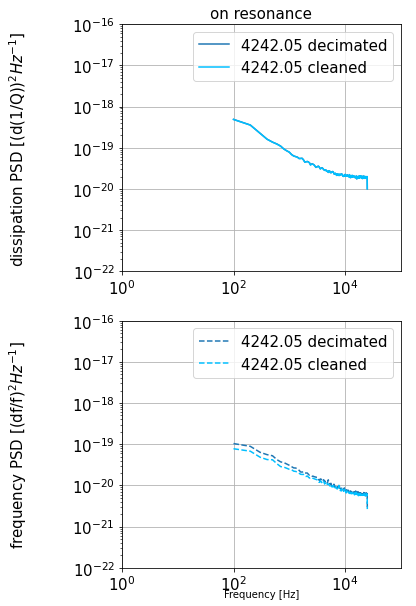

In [7]:
## Do the cleaning of the noise file
powers, PSDs, res, timestreams = Thf.CleanPSDs(
    nse_files[0], 
    vna_file, 
    PSD_lo_f=chunk_up_to, 
    PSD_hi_f=decimate_down_to, 
    f_transient=blank_fraction, 
    charFs=charFs, 
    charZs=charZs)

## Function to find time of rising edge

In [8]:
def find_rising_edge(xdata, ydata, offset_sec = 0.001, verbose=True):
    ## Window limits
    s = offset_sec
    e = s + time_btw_pulse

    ## Pull the data in this region
    xvals = xdata[(xdata>s)*(xdata<e)]
    yvals = ydata[(xdata>s)*(xdata<e)]

    ## Calculate something proportional to slope
    yslp  = yvals[1:]-yvals[:-1]

    ## Find the point with maximum (positive) slope
    smax  = np.max(yslp)
    xmax  = xvals[1:][np.argmax(yslp)]
    ymax  = yvals[1:][np.argmax(yslp)]

    if verbose:
        print("Rising edge found at",delta_sec+xmax,"sec")
        print("Use a window starting at",xmax,"sec")
    
    return xmax, ymax

## Pulse cleaning

cleaning pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_2.800V_20221031_093936.h5
using VNA file:      /data/USRP_Laser_Data/20221031/20221031_093936/USRP_VNA_20221031_093936.h5
using noise file:    /data/USRP_Laser_Data/20221031/20221031_093936/USRP_Noise_20221031_093936_delta0.h5
decimated data by 20 to achieve requested upper bound of 5.000000e+04 Hz
saving clean_data to /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_2.800V_20221031_093936_cleaned.h5 because override=True!
/data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_2.800V_20221031_093936.h5
cleaning pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_2.820V_20221031_093936.h5
using VNA file:      /data/USRP_Laser_Data/20221031/20221031_093936/USRP_VNA_20221031_093936.h5
using noise file:    /data/USRP_Laser_Data/20221031/20221031_093936/USRP_Noise_20221031_093936_delta0.h5
decimated data by 20 to achieve requested upper bound of 5.000000e+04 Hz
saving clean_d

decimated data by 20 to achieve requested upper bound of 5.000000e+04 Hz
saving clean_data to /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_3.100V_20221031_093936_cleaned.h5 because override=True!
cleaning pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_3.120V_20221031_093936.h5
using VNA file:      /data/USRP_Laser_Data/20221031/20221031_093936/USRP_VNA_20221031_093936.h5
using noise file:    /data/USRP_Laser_Data/20221031/20221031_093936/USRP_Noise_20221031_093936_delta0.h5
decimated data by 20 to achieve requested upper bound of 5.000000e+04 Hz
saving clean_data to /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_3.120V_20221031_093936_cleaned.h5 because override=True!
cleaning pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_3.140V_20221031_093936.h5
using VNA file:      /data/USRP_Laser_Data/20221031/20221031_093936/USRP_VNA_20221031_093936.h5
using noise file:    /data/USRP_Laser_Data/20221031/20221031_093936

saving clean_data to /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_3.400V_20221031_093936_cleaned.h5 because override=True!
/data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_3.400V_20221031_093936.h5
cleaning pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_3.420V_20221031_093936.h5
using VNA file:      /data/USRP_Laser_Data/20221031/20221031_093936/USRP_VNA_20221031_093936.h5
using noise file:    /data/USRP_Laser_Data/20221031/20221031_093936/USRP_Noise_20221031_093936_delta0.h5
decimated data by 20 to achieve requested upper bound of 5.000000e+04 Hz
saving clean_data to /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_3.420V_20221031_093936_cleaned.h5 because override=True!
cleaning pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_3.440V_20221031_093936.h5
using VNA file:      /data/USRP_Laser_Data/20221031/20221031_093936/USRP_VNA_20221031_093936.h5
using noise file:    /data/USRP_Laser_Data/20221031/20

saving clean_data to /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_3.700V_20221031_093936_cleaned.h5 because override=True!
cleaning pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_3.720V_20221031_093936.h5
using VNA file:      /data/USRP_Laser_Data/20221031/20221031_093936/USRP_VNA_20221031_093936.h5
using noise file:    /data/USRP_Laser_Data/20221031/20221031_093936/USRP_Noise_20221031_093936_delta0.h5
decimated data by 20 to achieve requested upper bound of 5.000000e+04 Hz
saving clean_data to /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_3.720V_20221031_093936_cleaned.h5 because override=True!
cleaning pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_3.740V_20221031_093936.h5
using VNA file:      /data/USRP_Laser_Data/20221031/20221031_093936/USRP_VNA_20221031_093936.h5
using noise file:    /data/USRP_Laser_Data/20221031/20221031_093936/USRP_Noise_20221031_093936_delta0.h5
decimated data by 20 to achieve req

/data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_4.000V_20221031_093936.h5
cleaning pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_4.020V_20221031_093936.h5
using VNA file:      /data/USRP_Laser_Data/20221031/20221031_093936/USRP_VNA_20221031_093936.h5
using noise file:    /data/USRP_Laser_Data/20221031/20221031_093936/USRP_Noise_20221031_093936_delta0.h5
decimated data by 20 to achieve requested upper bound of 5.000000e+04 Hz
saving clean_data to /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_4.020V_20221031_093936_cleaned.h5 because override=True!
cleaning pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_4.040V_20221031_093936.h5
using VNA file:      /data/USRP_Laser_Data/20221031/20221031_093936/USRP_VNA_20221031_093936.h5
using noise file:    /data/USRP_Laser_Data/20221031/20221031_093936/USRP_Noise_20221031_093936_delta0.h5
decimated data by 20 to achieve requested upper bound of 5.000000e+04 Hz
saving clean_d

decimated data by 20 to achieve requested upper bound of 5.000000e+04 Hz
saving clean_data to /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_4.320V_20221031_093936_cleaned.h5 because override=True!
cleaning pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_4.340V_20221031_093936.h5
using VNA file:      /data/USRP_Laser_Data/20221031/20221031_093936/USRP_VNA_20221031_093936.h5
using noise file:    /data/USRP_Laser_Data/20221031/20221031_093936/USRP_Noise_20221031_093936_delta0.h5
decimated data by 20 to achieve requested upper bound of 5.000000e+04 Hz
saving clean_data to /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_4.340V_20221031_093936_cleaned.h5 because override=True!
cleaning pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_4.360V_20221031_093936.h5
using VNA file:      /data/USRP_Laser_Data/20221031/20221031_093936/USRP_VNA_20221031_093936.h5
using noise file:    /data/USRP_Laser_Data/20221031/20221031_093936

decimated data by 20 to achieve requested upper bound of 5.000000e+04 Hz
saving clean_data to /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_4.620V_20221031_093936_cleaned.h5 because override=True!
cleaning pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_4.640V_20221031_093936.h5
using VNA file:      /data/USRP_Laser_Data/20221031/20221031_093936/USRP_VNA_20221031_093936.h5
using noise file:    /data/USRP_Laser_Data/20221031/20221031_093936/USRP_Noise_20221031_093936_delta0.h5
decimated data by 20 to achieve requested upper bound of 5.000000e+04 Hz
saving clean_data to /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_4.640V_20221031_093936_cleaned.h5 because override=True!
cleaning pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_4.660V_20221031_093936.h5
using VNA file:      /data/USRP_Laser_Data/20221031/20221031_093936/USRP_VNA_20221031_093936.h5
using noise file:    /data/USRP_Laser_Data/20221031/20221031_093936

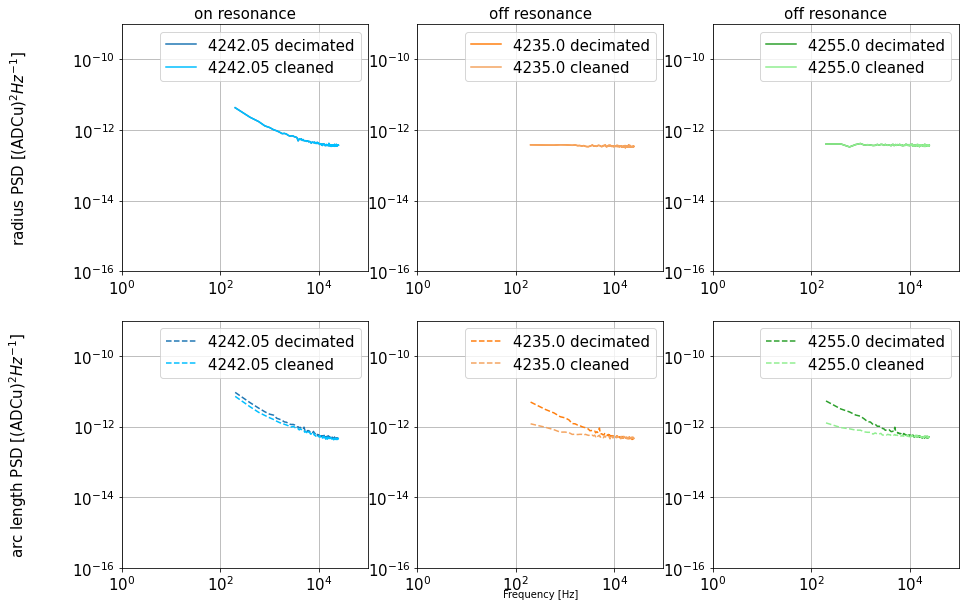

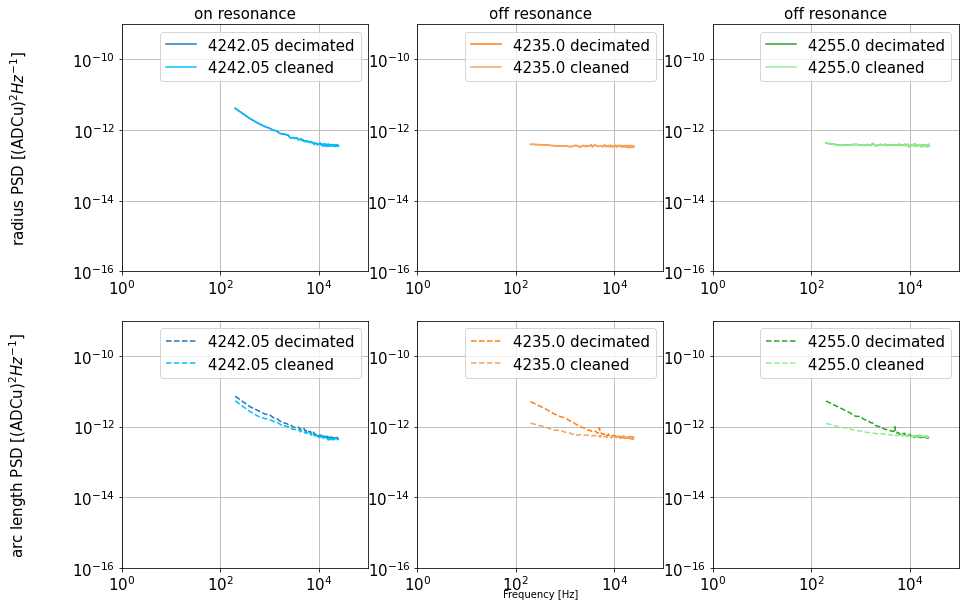

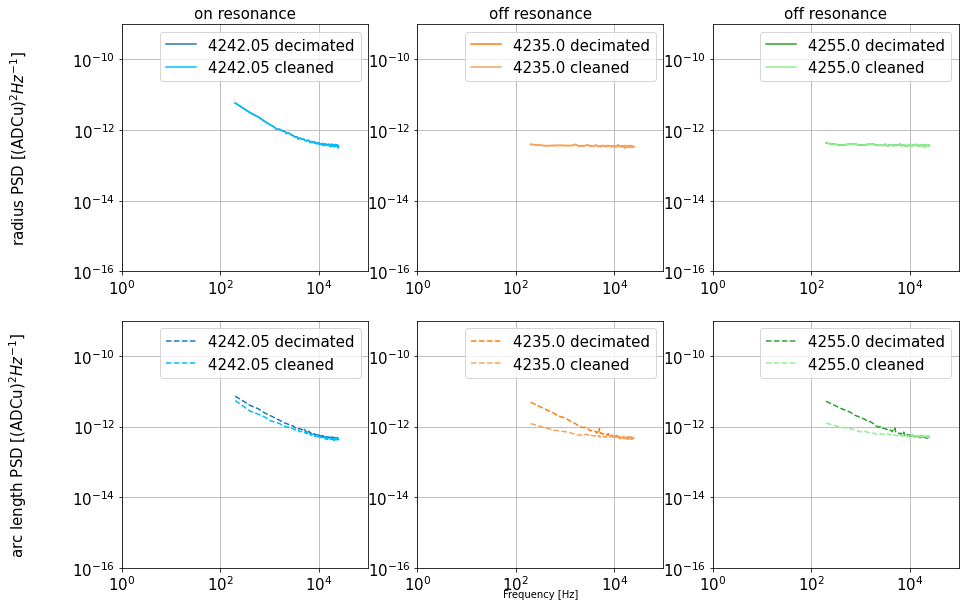

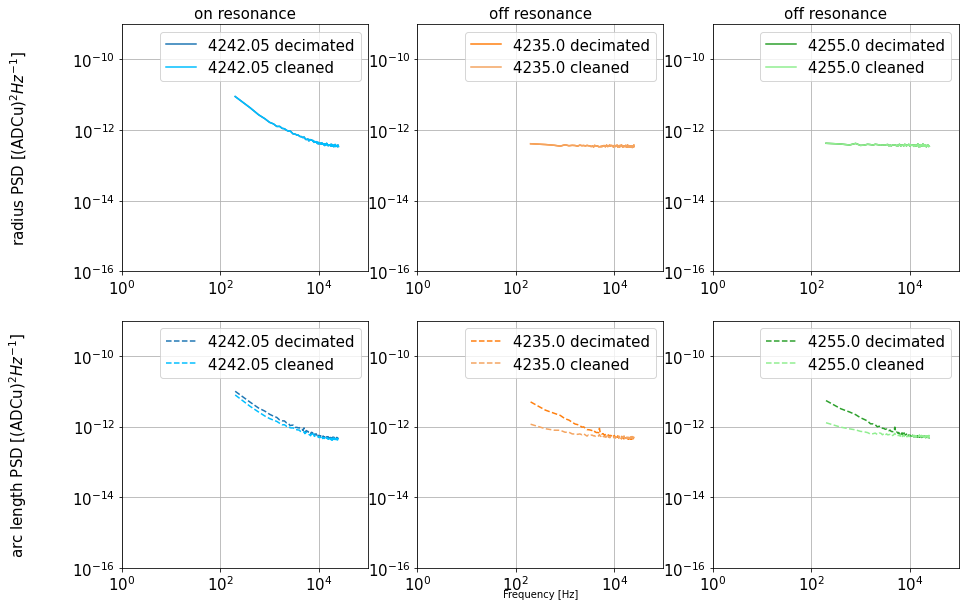

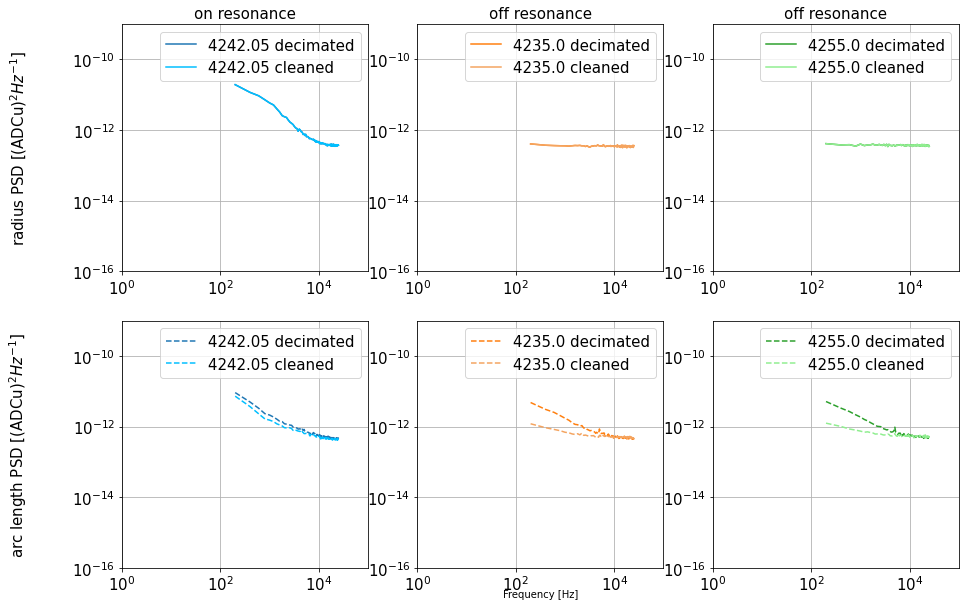

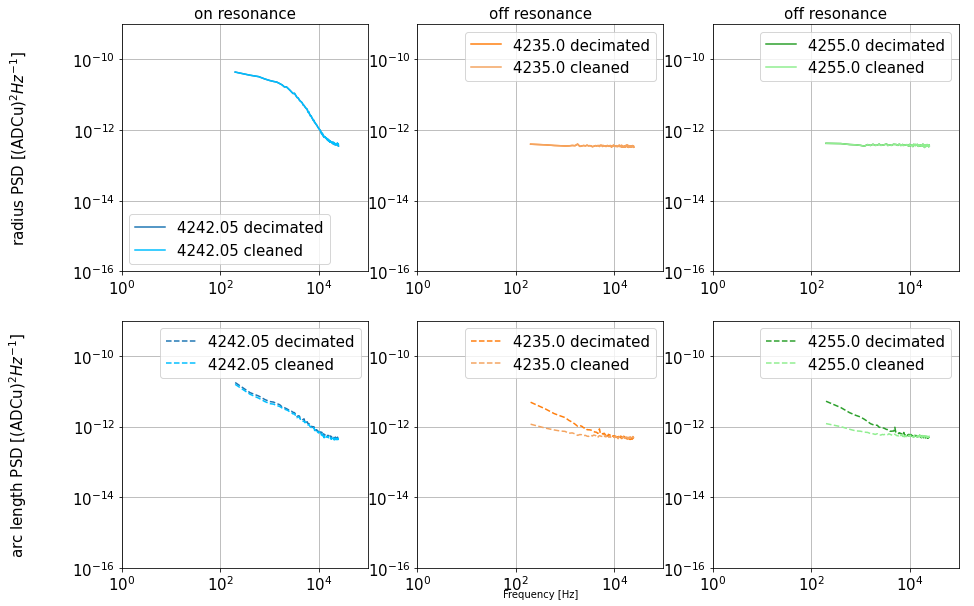

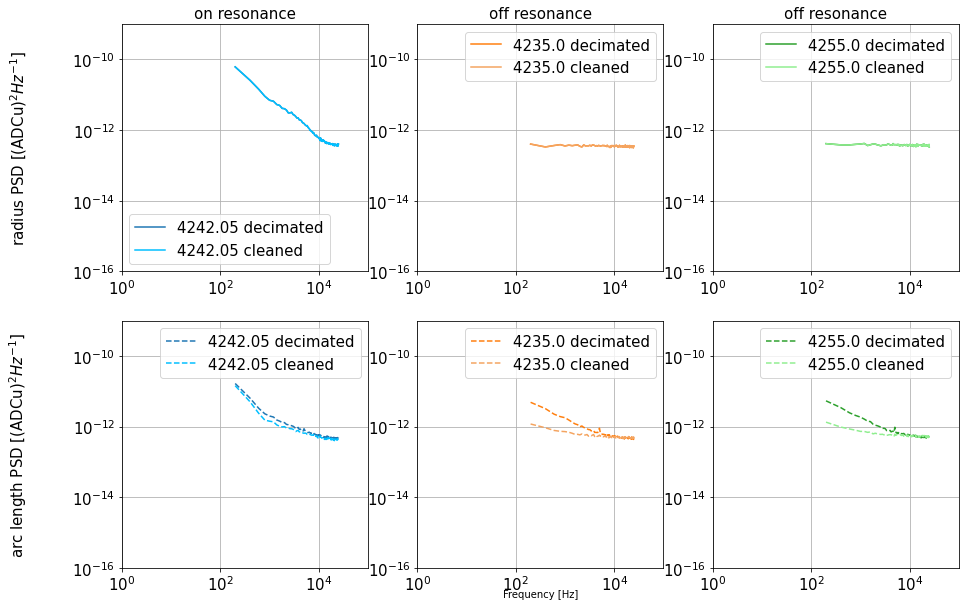

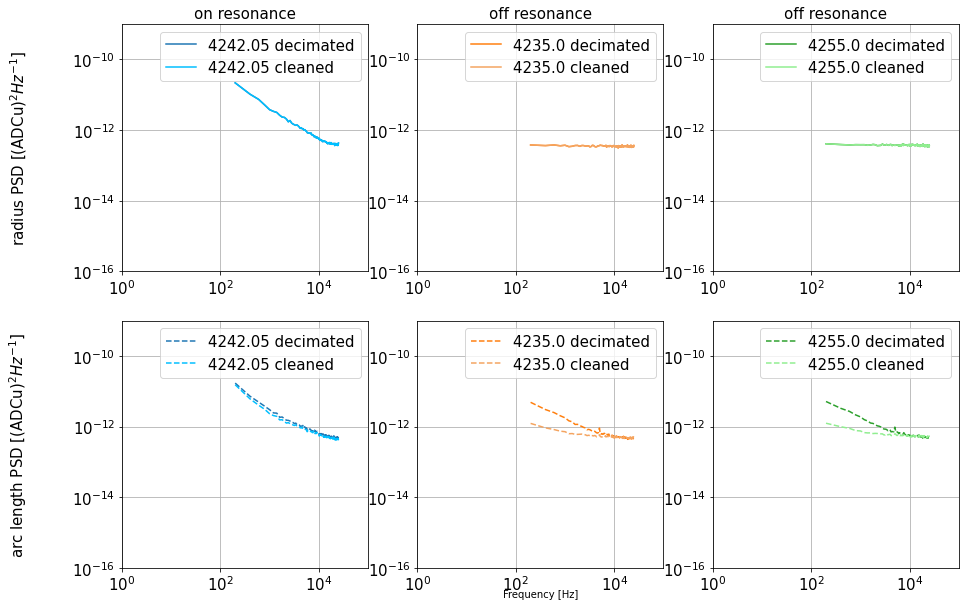

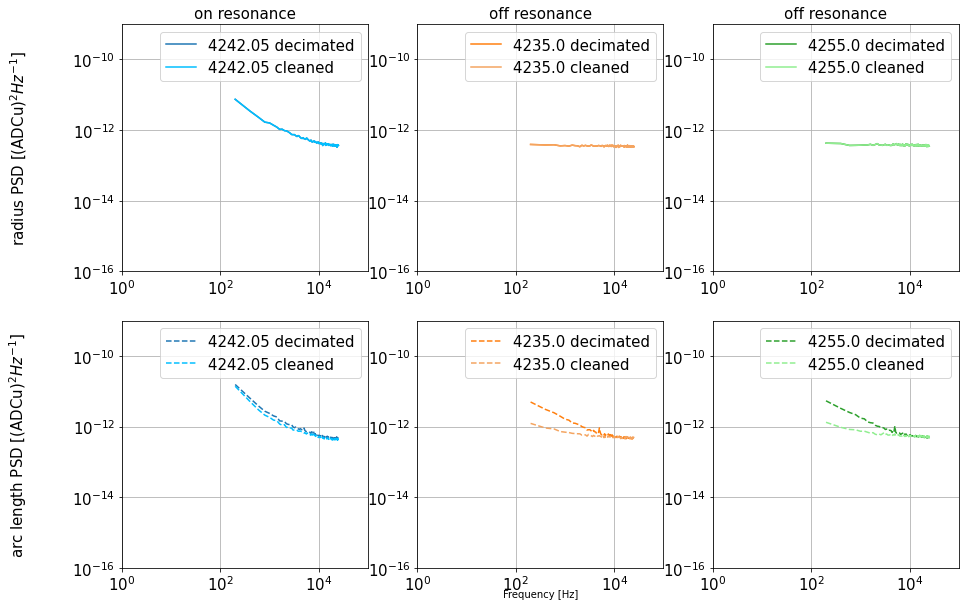

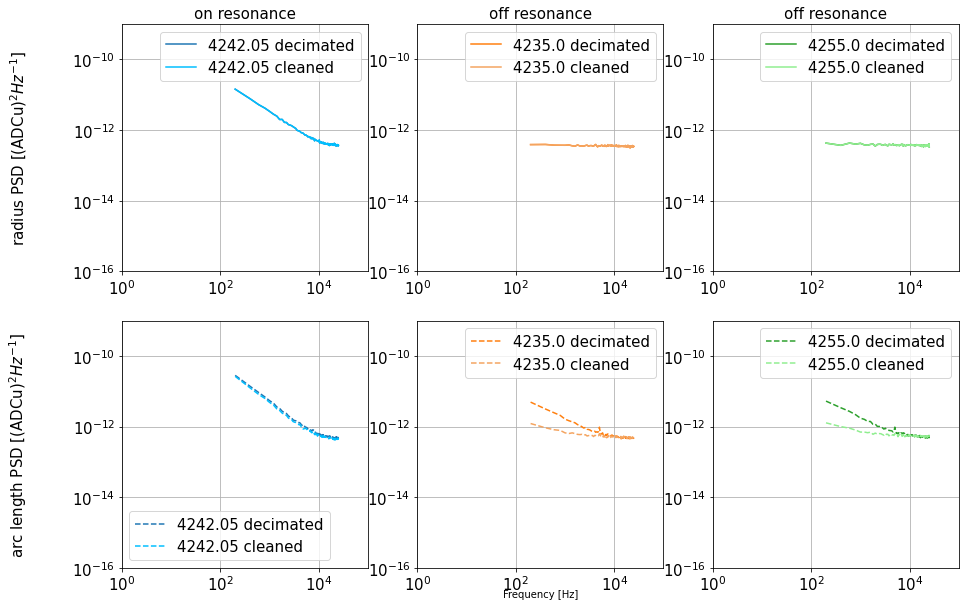

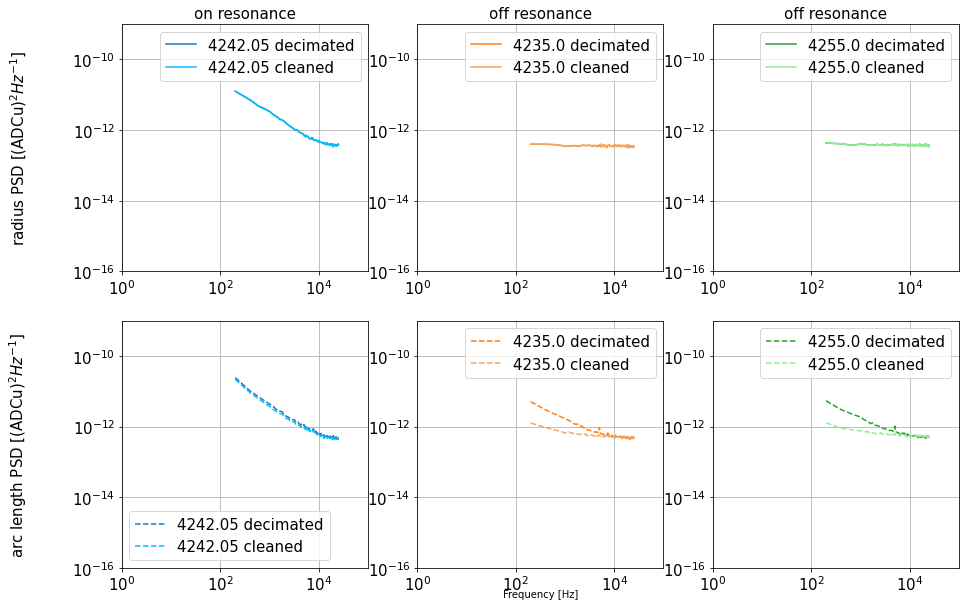

In [9]:
files_to_skip = 0
# window_shift_seconds = 500e-6 # -10e-6
win_shift_samples = 0
# stdev_cut = 0.9
verbose = False 
j = 0

# bad_pls_obj = np.empty( len(led_files[files_to_skip::2]), dtype=object )

for pulse_file in led_files[files_to_skip:]:
    print('===================')
    print('cleaning pulse file:',pulse_file)
    print('using VNA file:     ',vna_file)
    print('using noise file:   ',nse_files[0])
    noise_file = nse_files[0]

    ## Determine how much additional decimation to apply
    pulse_noise, pulse_info = PUf.unavg_noi(pulse_file)
    pulse_fs = 1./pulse_info['sampling period']
    pulse_cleaning_decimation = int(pulse_fs/decimate_down_to)

    if verbose:
        print('loaded pulse data')

    ## Get the decimated timestream and frequency step
    pulse_noise = Prf.average_decimate(pulse_noise,pulse_cleaning_decimation)
    pulse_fs /= pulse_cleaning_decimation

    print('decimated data by ' + str(pulse_cleaning_decimation) + ' to achieve requested upper bound of ' + '{:2e}'.format(decimate_down_to) + ' Hz' )

    ## Create a new array of of frequency space with the applied decimation
    sampling_rate = pulse_fs
    samples_per_pulse = int(time_btw_pulse*sampling_rate)
    N = int(samples_per_pulse / 2) ## We look at the second half of a pulse window only
    T = N/sampling_rate
    t,f = Prf.build_t_and_f(N,sampling_rate)
    
    if verbose:
        print("Sampling rate:",sampling_rate,"per sec")
        print("Samples per pulse window:",samples_per_pulse)
        print("N=:",N,"; T=",T,";",np.shape(f))
    
    ## Define the regions where pulses exist
    ## =====================================
    
    ## This defines where (in # of pulse windows) to start looking for pulses
    pulse_start = int(total_pulses * blank_fraction)
    if verbose:
        print("Starting pulse partitioning after", pulse_start, "windows (of",total_pulses,")")
    
    ## How many samples to shift the pulse window definition
    window_shift = win_shift_samples # int(window_shift_seconds * sampling_rate) @@@@@@@@@
    if verbose:
        print("Shifting pulse window by", window_shift, "samples")
    
    ## Create empty arrays to store our results in
    noise_averages = np.zeros((3),dtype=np.complex128)
    J_r = np.zeros((N,3)); J_arc = np.zeros((N,3))
    
    ## Create a plot to store waveforms
    if verbose:
        fi0 = plt.figure(pulse_file+"_a")
        ax0 = fi0.gca()
        ax0.set_xlabel("Sample")
        ax0.set_ylabel(r"$\log_{10}|S_{21}|$")
        ax0.set_title(".".join(pulse_file.split("/")[-1].split(".")[0:-1]))
        
        fi1 = plt.figure(pulse_file+"_b")
        ax1 = fi1.gca()
        ax1.set_xlabel(r"$\Re(S_{21})$")
        ax1.set_ylabel(r"$\Im(S_{21})$")
        ax1.set_title(".".join(pulse_file.split("/")[-1].split(".")[0:-1]))
        
#     ## Create a bad pulse window index array
#     bad_pulses = np.array([])
#     pulse_bad  = False
    
    ## Start the loop over pulse windows
    k=0
    for pulse_i in range(pulse_start,int(total_pulses),1):
        
        ## Define the sample index where this pulse window ends
        pulse_i_end = int((pulse_i+1)*samples_per_pulse)
        
        ## Define the start of the pulse free region (period after pulse, before the next one, where it should be baseline noise)
        no_pulse_idx_start = pulse_i_end - N + window_shift
        
        ## Define the end of the window (where the pulse-free region ends)
        no_pulse_idx_end = pulse_i_end + window_shift
        
        ## Grab the timestream in that region and average it
        no_pulse_chunk = pulse_noise[no_pulse_idx_start:no_pulse_idx_end,:]
        
        ## Calculate some means and stdevs of this pulse-free timestream
        m = np.mean(no_pulse_chunk,axis=0,dtype=np.complex128)
        s = np.std( no_pulse_chunk,axis=0,dtype=np.complex128)
        
        ## Check the maximum value in this pulse free region
        mx = np.abs(np.max(np.log10(abs(no_pulse_chunk[:,0]))))
        z  = np.abs((mx-np.log10(abs(m[0]))))/np.abs(np.log10(abs(s[0])))
        
#         if (pulse_bad):
#             bad_pulses = np.append(bad_pulses, pulse_i)
#             pulse_bad  = False
#             continue
        
#         if (z > stdev_cut):
# #             print("!! -->",pulse_file, pulse_i, z)
# #             ax0.plot(np.log10(abs(no_pulse_chunk[:,0])),alpha=0.25)
#             bad_pulses = np.append(bad_pulses, pulse_i)
#             pulse_bad  = True
#             continue
        
        ## Keep a running average of the noise across all pulse regions
        noise_averages += m / num_pulses    
        
        ## Plot the pulse free region against time
        if verbose: # and (k==0):
            ax0.plot(np.log10(abs(no_pulse_chunk[:,0])),alpha=0.25)
            ax1.scatter(no_pulse_chunk[:,0].real,no_pulse_chunk[:,0].imag,alpha=0.25)

        ## Convert to the electronics basis and compute the J objects
        r_chunk,arc_chunk,_,_= Prf.electronics_basis(no_pulse_chunk)
        J_r += abs(Prf.discrete_FT(r_chunk))**2 / num_pulses * 2 * T
        J_arc += abs(Prf.discrete_FT(arc_chunk))**2 / num_pulses * 2 * T
#         J_r += abs(Prf.discrete_FT(r_chunk))**2  * 2 * T
#         J_arc += abs(Prf.discrete_FT(arc_chunk))**2  * 2 * T
        
        k+=1
    
#     noise_averages = noise_averages / k  
#     J_r   = J_r   / k
#     J_arc = J_arc / k
    
#     bad_pls_obj[j] = bad_pulses
    
    if verbose:
        print("Searched",k,"pulse windows")
        print('used ' + str(k) + ' chunks to find quiescent point')
        ax0.axhline(y=np.log10(abs(noise_averages[0])),color="k",ls='--')
    
#     if j % 4 == 0:
#         fig, ax = plt.subplots(1,2,figsize=(5,10))
#         ax[0].plot(f[f>0],J_r[f>0],color='C'+str(j%10))
#         ax[1].plot(f[f>0],J_arc[f>0],color='C'+str(j%10))
#         ax[0].set_yscale('log'); ax[0].set_xscale('log'); ax[1].set_yscale('log'); ax[1].set_xscale('log')

    ## Pull the two real quantities from the complex timestream averages
    radius_averages = abs(noise_averages)
    angle_averages  = np.angle(noise_averages)
    if verbose:
        print(radius_averages)
        print(angle_averages)

    ## Rotate the timestream by the averange angle, then get the rotated phase timestream
    pulse_timestream_rotated = pulse_noise*np.exp(-1j*angle_averages)
    angle_timestream = np.angle(pulse_timestream_rotated)

    ## Subtract off the average magnitude value and calculate an arc length
    radius = abs(pulse_noise) - radius_averages
    arc    = angle_timestream*radius_averages

    ## Create output containers for the clean timestreams
    radius_clean = np.zeros(radius.shape)
    arc_clean    = np.zeros(arc.shape)

    if verbose:
        print('built radius and arc length timestreams given by quiescent point')
        print(noise_file)
        
    ## Pull the dictionary containing cleaning coefficients from the noise timestream
    _,data_info = PUf.clean_noi(noise_file[:-3]+'_cleaned.h5')

    ## Loop over each tone in the radius timestream
    for t in range(radius.shape[1]):
        ## Pull the coefficients from the noise cleaning
        radius_coefficient = data_info['radius cleaning coefficient'][t]
        arc_coefficient    = data_info['arc cleaning coefficient'][t]

        ## Clean each tone with the off-resonance tones
        if t == 0:
            off_tone_idcs = [1,2]
        elif t == 1:
            off_tone_idcs = [2]
        elif t == 2:
            off_tone_idcs = [1]


        ## Perform the radius cleaning
        off_tone_radius = np.mean(radius[:,off_tone_idcs],axis=1,dtype=np.float64)
        radius_clean[:,t] = radius[:,t] - radius_coefficient*off_tone_radius

        ## Perform the arc length cleaning
        off_tone_arc = np.mean(arc[:,off_tone_idcs],axis=1,dtype=np.float64)
        arc_clean[:,t] = arc[:,t] - arc_coefficient*off_tone_arc

        if verbose: 
            print('cleaned tone ' + str(t))

    ## Subtract off the mean from cleaned radius and arc length timestreams
    radius_clean -= np.mean(radius_clean,axis=0,dtype='float64')
    arc_clean -= np.mean(arc_clean,axis=0,dtype='float64')
    
    ## Save the clean timestreams to a file
    pulse_noise_clean = Prf.save_clean_timestreams(pulse_file,\
                                                   radius_averages,\
                                                   angle_averages,\
                                                   radius_clean,\
                                                   arc_clean,\
                                                   sampling_rate,\
                                                   timestreams['radius coefficient'],\
                                                   timestreams['arc coefficient'],\
                                                   override=True)

    ## Calculate the PSDs for each of the cleaned pulses
    J_r_clean = np.zeros((N,3)); J_arc_clean = np.zeros((N,3))
    for pulse_i in range(pulse_start,int(total_pulses),1):
#         if pulse_i in bad_pulses:
#             continue
        
        ## Define the sample index where this pulse window ends
        pulse_i_end = int((pulse_i+1)*samples_per_pulse) 
        
        ## Define the start of the pulse free region (period after pulse, before the next one, where it should be baseline noise)
        no_pulse_idx_start = pulse_i_end - N + window_shift
        
        ## Define the end of the window (where the pulse-free region ends)
        no_pulse_idx_end = pulse_i_end + window_shift
        
        ## Grab the timestream in that region
        no_pulse_chunk = pulse_noise_clean[no_pulse_idx_start:no_pulse_idx_end,:]

        ## Convert the pulse-free region to electronics basis
        r_chunk,arc_chunk,_,_= Prf.electronics_basis(no_pulse_chunk)
        
        ## Compute the PSDs
#         J_r_clean += abs(Prf.discrete_FT(r_chunk))**2 / num_pulses * 2 * T
#         J_arc_clean += abs(Prf.discrete_FT(arc_chunk))**2 / num_pulses * 2 * T
        J_r_clean += abs(Prf.discrete_FT(r_chunk))**2 / k * 2 * T
        J_arc_clean += abs(Prf.discrete_FT(arc_chunk))**2 / k * 2 * T


    ## Trim the output to the positive frequency region only
    J_r = J_r[f>=0]; J_r_clean = J_r_clean[f>=0]; J_arc = J_arc[f>=0]; J_arc_clean = J_arc_clean[f>=0]
    
    ## Every tenth files, show the PSDs
    if j % 10 == 0:
        print(pulse_file)
        fig_0, axes_0 = plt.subplots(2,3,sharex=True,sharey='row',figsize=(5*3,10))
        
        Prf.plot_PSDs(f[f>0],J_r,J_arc,pulse_file,\
                      ['radius','arc length'],units=['ADCu','ADCu'],savefig='electronics',\
                      data_freqs=pulse_info['search freqs'],\
                      P_1_clean=J_r_clean,P_2_clean=J_arc_clean,\
                      fig_0=fig_0,axes_0=axes_0)

    j += 1

## Pulse averaging

averaging pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_2.800V_20221031_093936.h5
loaded clean pulse data
sampling_rate: 50000.0
further decimation by 1 complete
Used 800 pulses to average
deleted an old pulse shape
averaging pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_2.820V_20221031_093936.h5
loaded clean pulse data
sampling_rate: 50000.0
further decimation by 1 complete
Used 800 pulses to average
deleted an old pulse shape
averaging pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_2.840V_20221031_093936.h5
loaded clean pulse data
sampling_rate: 50000.0
further decimation by 1 complete
Used 800 pulses to average
deleted an old pulse shape
averaging pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_2.860V_20221031_093936.h5
loaded clean pulse data
sampling_rate: 50000.0
further decimation by 1 complete
Used 800 pulses to average
deleted an old pulse shape
averaging pulse file: /data/USRP

<ipython-input-18-edf0af435824>:60: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


further decimation by 1 complete
Used 800 pulses to average
deleted an old pulse shape
averaging pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_3.240V_20221031_093936.h5
loaded clean pulse data
sampling_rate: 50000.0
further decimation by 1 complete
Used 800 pulses to average
deleted an old pulse shape
averaging pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_3.260V_20221031_093936.h5
loaded clean pulse data
sampling_rate: 50000.0
further decimation by 1 complete
Used 800 pulses to average
deleted an old pulse shape
averaging pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_3.280V_20221031_093936.h5
loaded clean pulse data
sampling_rate: 50000.0
further decimation by 1 complete
Used 800 pulses to average
deleted an old pulse shape
averaging pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_3.300V_20221031_093936.h5
loaded clean pulse data
sampling_rate: 50000.0
further decimation by 1 complete

further decimation by 1 complete
Used 800 pulses to average
deleted an old pulse shape
averaging pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_3.900V_20221031_093936.h5
loaded clean pulse data
sampling_rate: 50000.0
further decimation by 1 complete
Used 800 pulses to average
deleted an old pulse shape
averaging pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_3.920V_20221031_093936.h5
loaded clean pulse data
sampling_rate: 50000.0
further decimation by 1 complete
Used 800 pulses to average
deleted an old pulse shape
averaging pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_3.940V_20221031_093936.h5
loaded clean pulse data
sampling_rate: 50000.0
further decimation by 1 complete
Used 800 pulses to average
deleted an old pulse shape
averaging pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_3.960V_20221031_093936.h5
loaded clean pulse data
sampling_rate: 50000.0
further decimation by 1 complete

further decimation by 1 complete
Used 800 pulses to average
deleted an old pulse shape
averaging pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_4.540V_20221031_093936.h5
loaded clean pulse data
sampling_rate: 50000.0
further decimation by 1 complete
Used 800 pulses to average
deleted an old pulse shape
averaging pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_4.560V_20221031_093936.h5
loaded clean pulse data
sampling_rate: 50000.0
further decimation by 1 complete
Used 800 pulses to average
deleted an old pulse shape
averaging pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_4.580V_20221031_093936.h5
loaded clean pulse data
sampling_rate: 50000.0
further decimation by 1 complete
Used 800 pulses to average
deleted an old pulse shape
averaging pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_4.600V_20221031_093936.h5
loaded clean pulse data
sampling_rate: 50000.0
further decimation by 1 complete

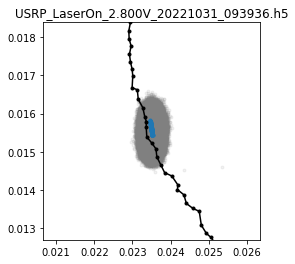

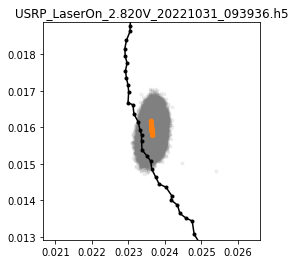

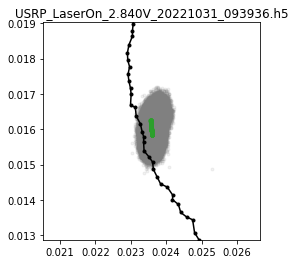

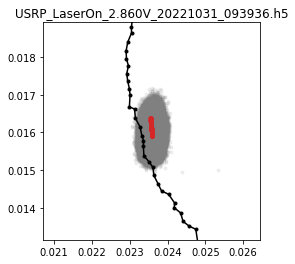

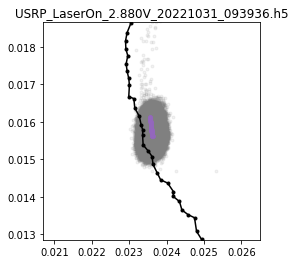

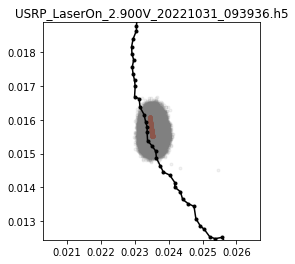

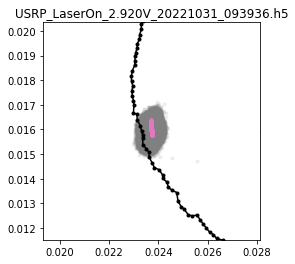

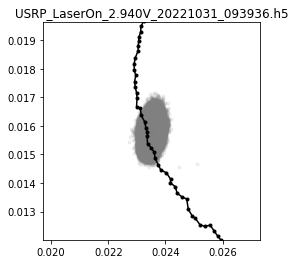

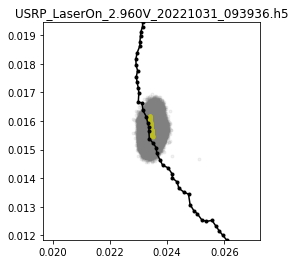

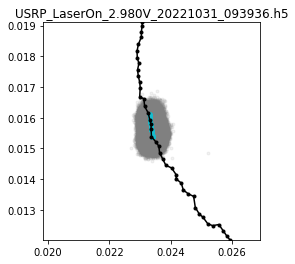

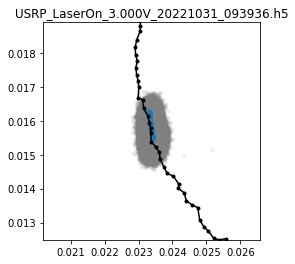

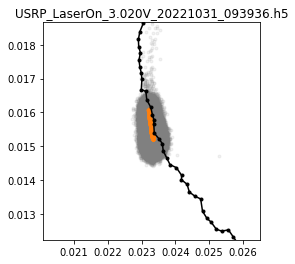

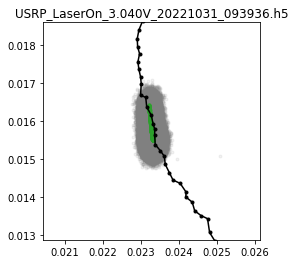

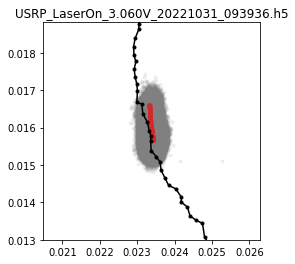

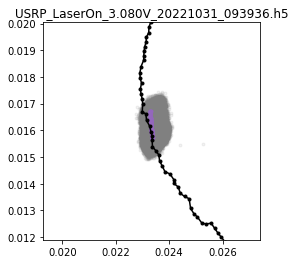

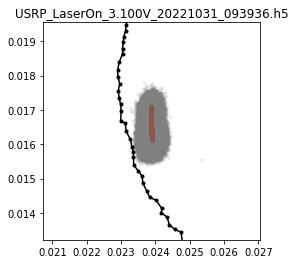

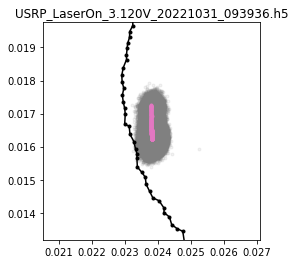

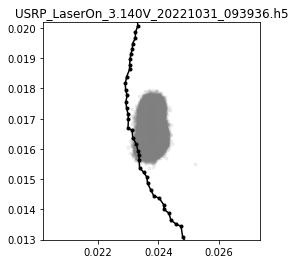

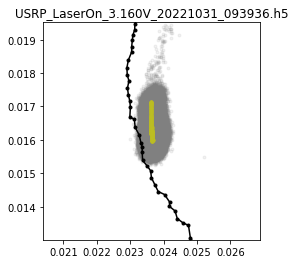

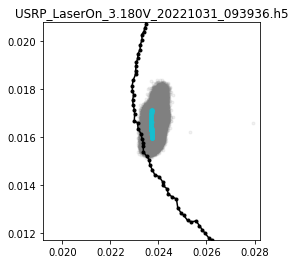

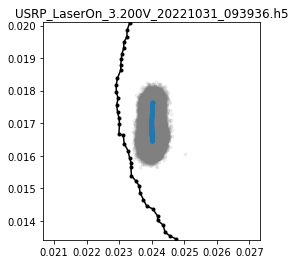

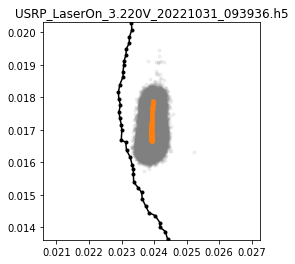

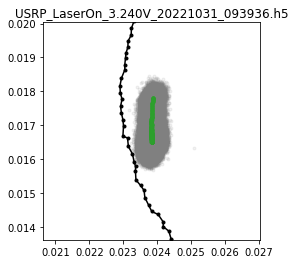

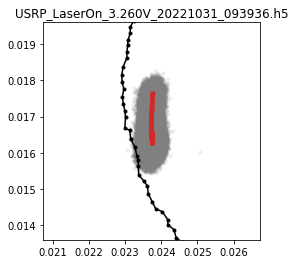

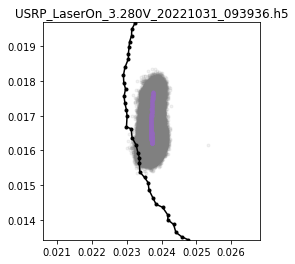

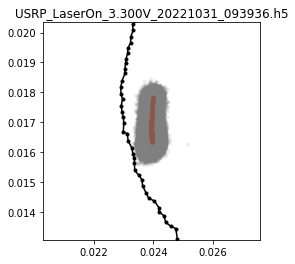

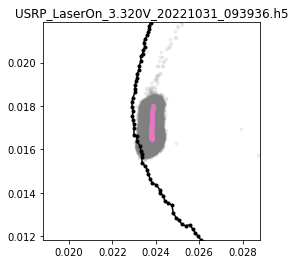

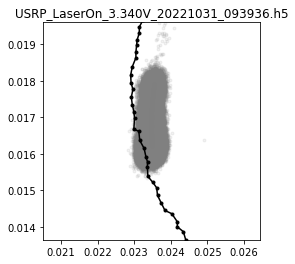

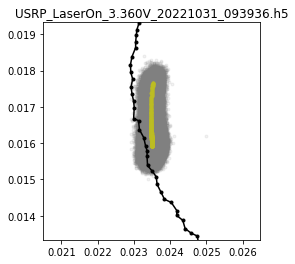

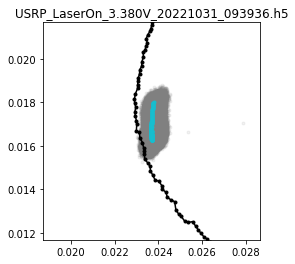

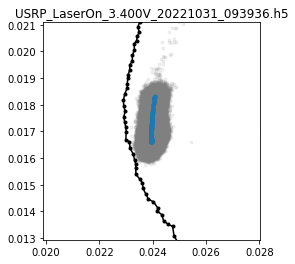

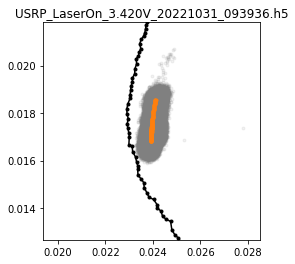

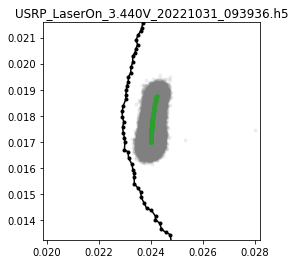

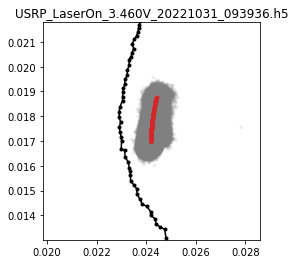

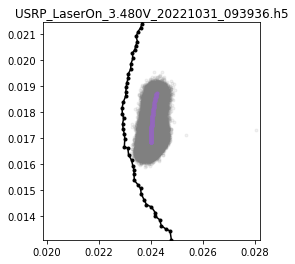

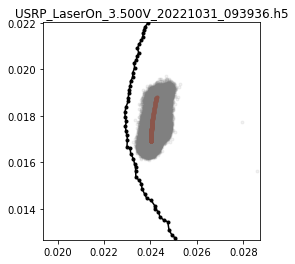

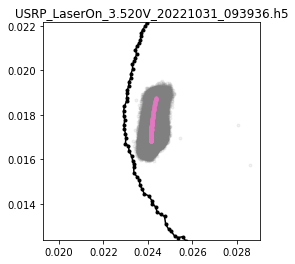

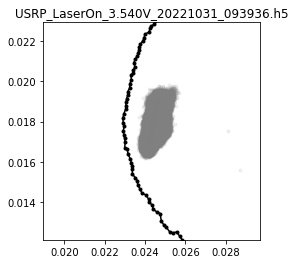

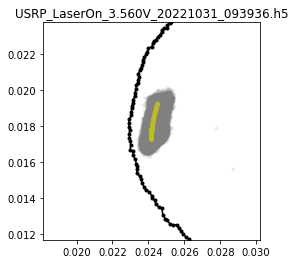

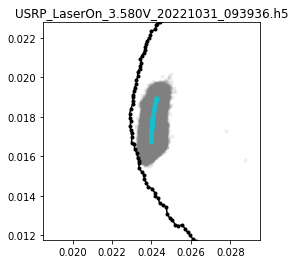

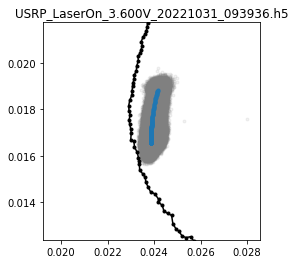

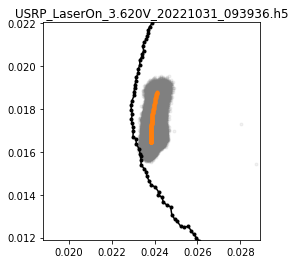

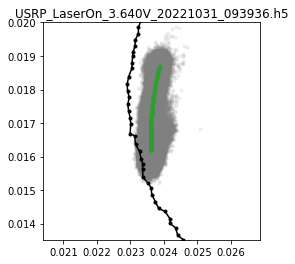

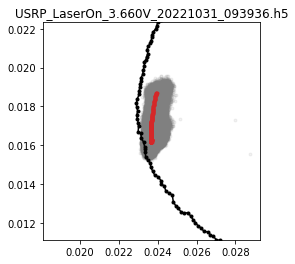

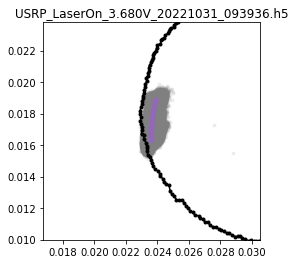

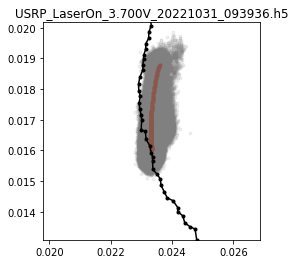

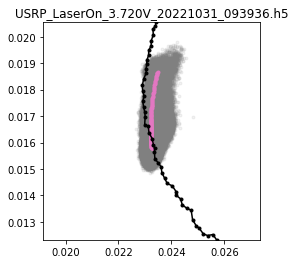

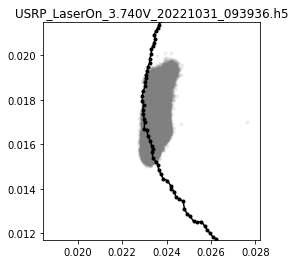

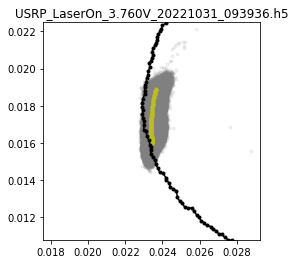

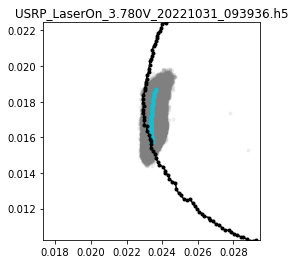

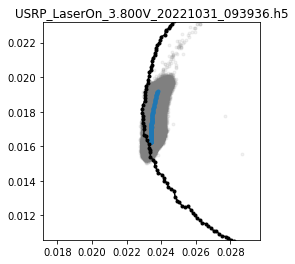

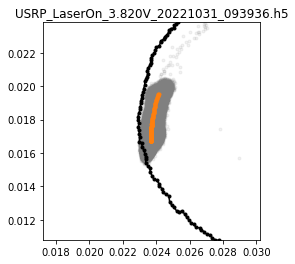

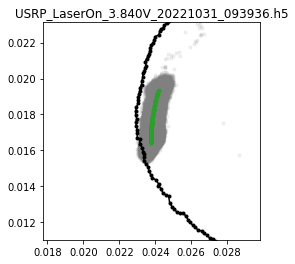

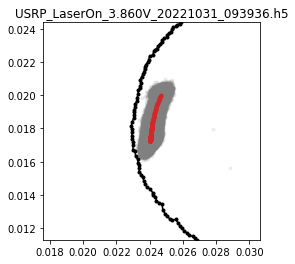

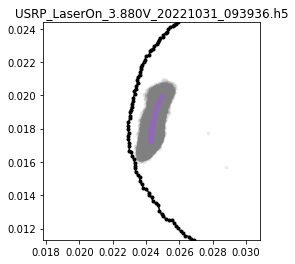

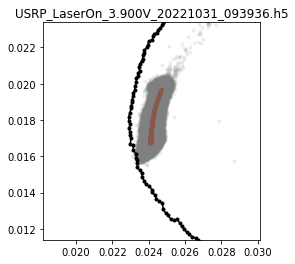

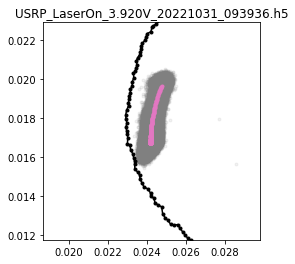

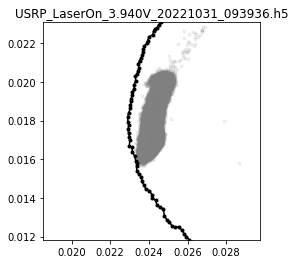

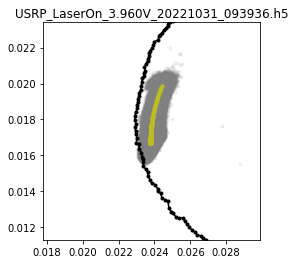

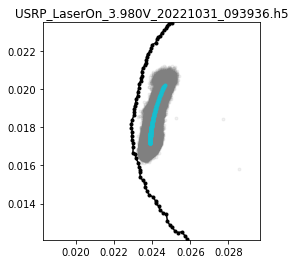

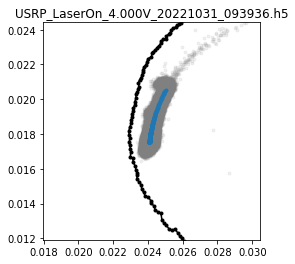

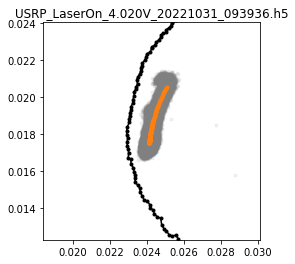

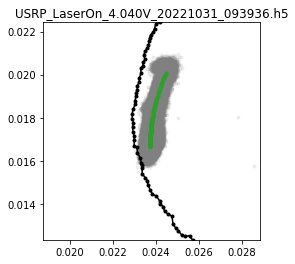

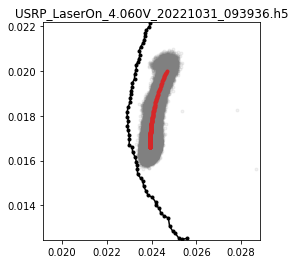

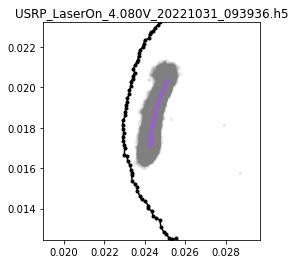

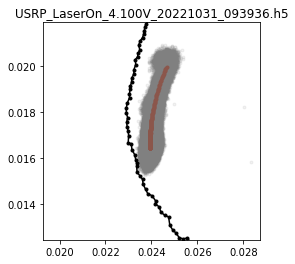

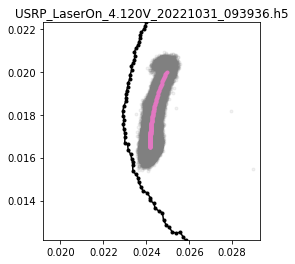

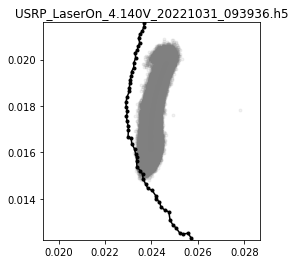

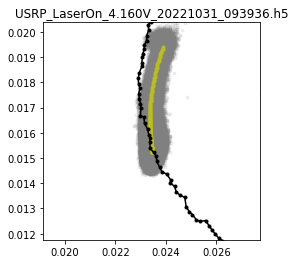

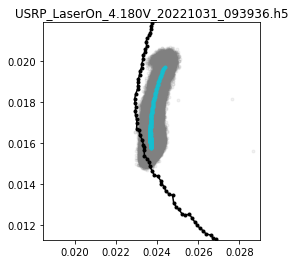

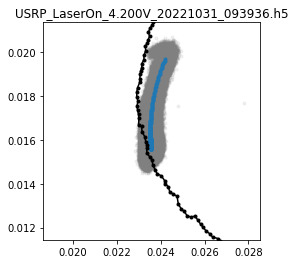

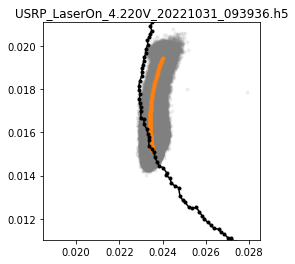

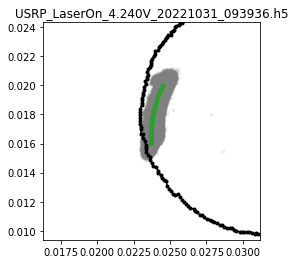

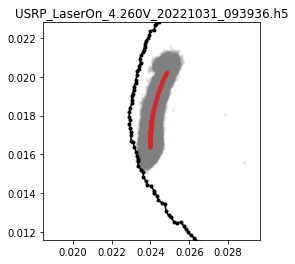

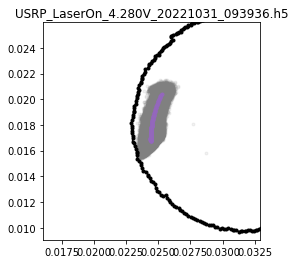

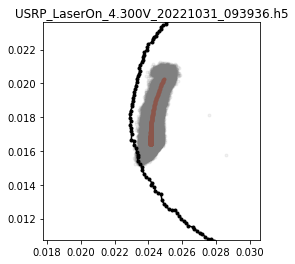

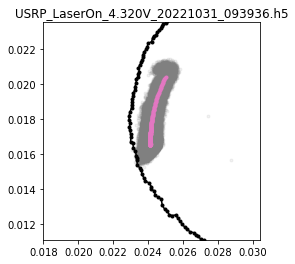

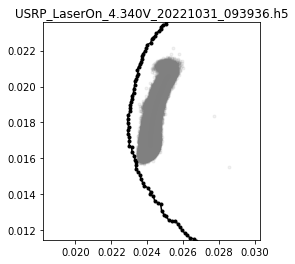

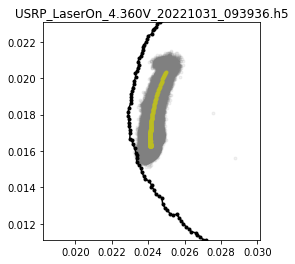

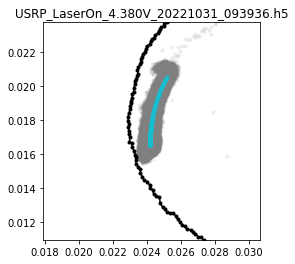

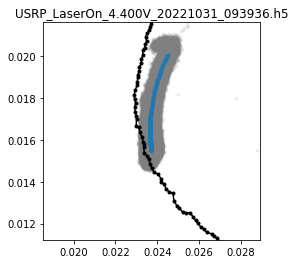

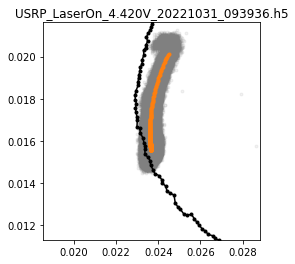

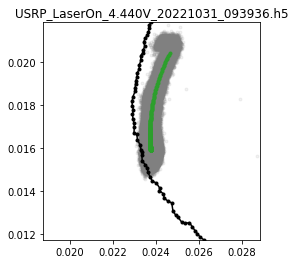

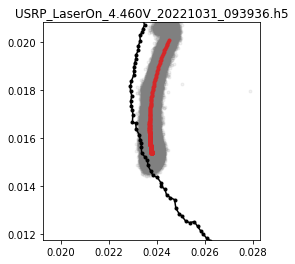

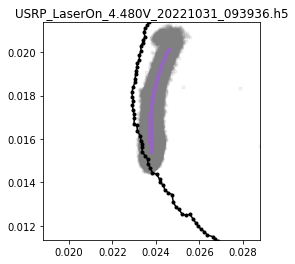

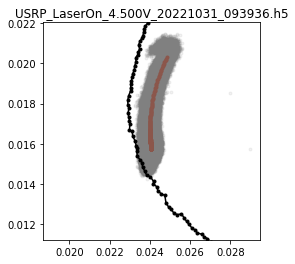

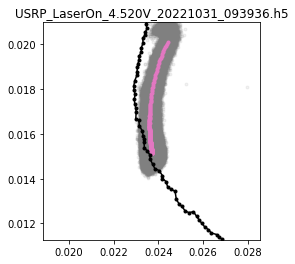

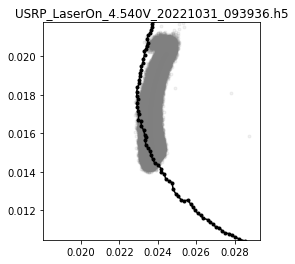

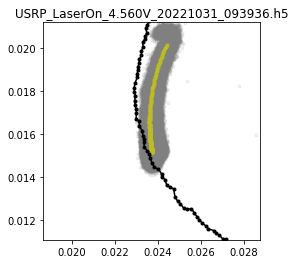

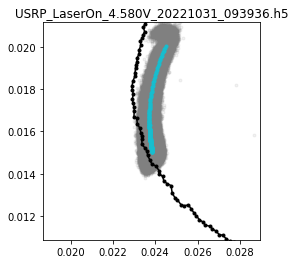

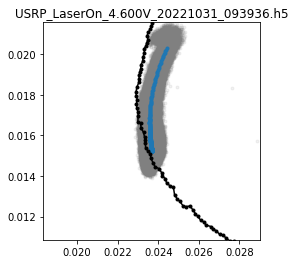

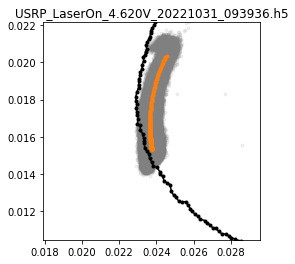

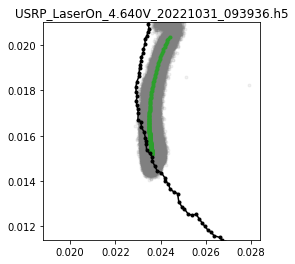

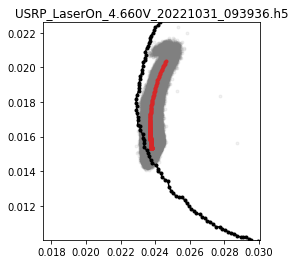

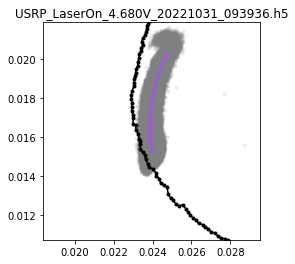

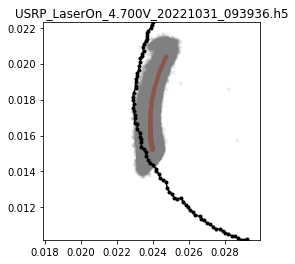

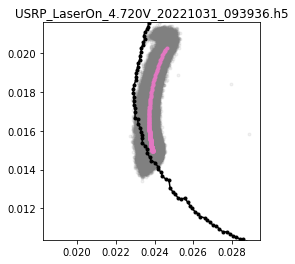

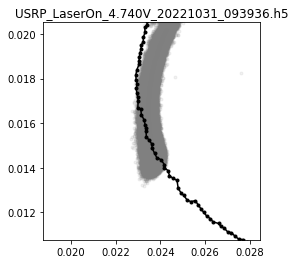

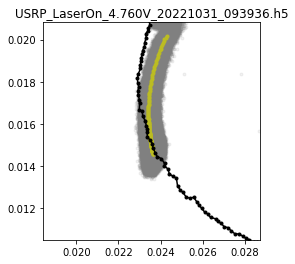

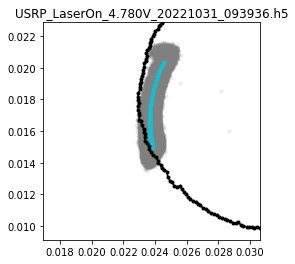

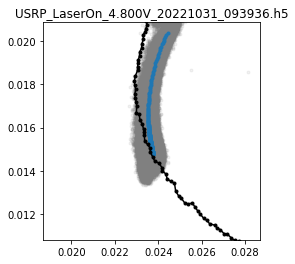

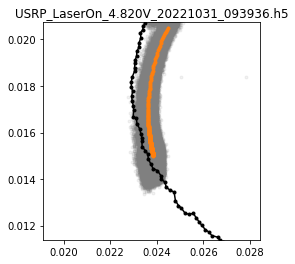

In [18]:
%matplotlib inline
NDF_pulse_avg = []
NDF_pulse_data_info = []
i = 0

fraction_to_keep = 0.5
# window_shift_seconds = 5e-3 # 100e-6
verbose = True

j = 0 
for pulse_file in led_files[files_to_skip:]:
    f,z = PUf.read_vna(vna_file)

    print('===================')
    print('averaging pulse file: ' + pulse_file)

    clean_pulse_file = pulse_file[:-3] + '_cleaned.h5'
    pulse_noise_clean,data_info = PUf.clean_noi(clean_pulse_file)
    if verbose: 
        print('loaded clean pulse data')        
        print('sampling_rate: ' + str(data_info['sampling_rate']))
    NDF_pulse_data_info.append(data_info)
    samples_per_pulse = data_info['sampling_rate'] * time_btw_pulse

    decimation = 1
    time = Prf.average_decimate(pulse_info['time'],decimation)
    pulse_noise_clean = Prf.average_decimate(pulse_noise_clean,decimation)
    samples_per_pulse_decimated = int(samples_per_pulse / decimation)
    sampling_rate = data_info['sampling_rate'] / decimation
    if verbose:
        print('further decimation by ' + str(decimation) + ' complete')

    # idcs_keep = np.zeros(int(num_pulses*samples_per_pulse_decimated*fraction_to_keep),dtype=int)
    pulse_avg = np.zeros(int(samples_per_pulse_decimated*fraction_to_keep),dtype=np.complex128)
    window_shift = 5 # win_shift_samples # 25 # -200 # int(window_shift_seconds*sampling_rate)
#     print(pulse_avg)
    pulse_start = int(total_pulses * blank_fraction)
    # print(idcs_keep.shape)
    k = 0
    for pulse_i in range(pulse_start,int(total_pulses),1):
        
#         if pulse_i in bad_pls_obj[j]:
#             continue
            
    #     print(pulse_i)
        pulse_idx_start = int(pulse_i*samples_per_pulse_decimated) + window_shift
        pulse_idx_end = int(round((pulse_i+fraction_to_keep)*samples_per_pulse_decimated,0)) + window_shift
    #     print(pulse_idx_start,pulse_idx_end)
        # print(np.arange(pulse_idx_start*2+samples_per_pulse,pulse_idx_end*2,1))
    #     print(pulse_idx_start*2+samples_per_pulse,pulse_idx_end*2)
        pulse_idx_list = np.arange(pulse_idx_start,pulse_idx_end,1,dtype=int)
    #     print(pulse_idx_list[0],pulse_idx_list[-1])
        pulse_avg += pulse_noise_clean[pulse_idx_list,0] #/ num_pulses
        k += 1
        
    pulse_avg = pulse_avg/k
        
    if j == j:
        color = 'C' + str(j % 10)
        plt.figure()
        plt.plot(pulse_noise_clean[:,0].real,pulse_noise_clean[:,0].imag,ls='',marker='.',alpha=0.1,color='grey')
        plt.plot(pulse_avg.real,pulse_avg.imag,color=color,ls='-',marker='.')
        plt.plot(z.real,z.imag,color='k',ls='-',marker='.',alpha=1.00)
        width = 50 * np.std(pulse_noise_clean[:,0].real)
        x_c = np.mean(pulse_avg.real)
        y_c = np.mean(pulse_avg.imag)
        plt.axis([x_c - width/2., x_c + width/2., y_c-width/2., y_c+width/2.])
        ax = plt.gca(); ax.set_aspect('equal','box')
        plt.title(pulse_file.split("/")[-1])
        # plt.savefig('noise and averaged pulse.png',dpi=100)
        
#     print(pulse_avg)
    print('Used ' + str(k) + ' pulses to average')
        # print('===================')
    NDF_pulse_avg.append(pulse_avg)
    with h5py.File(clean_pulse_file, "a") as fyle:
        if 'pulse_shape' in fyle.keys():
            del fyle['pulse_shape']
            print('deleted an old pulse shape')
        fyle.create_dataset('pulse_shape',data = np.asarray(pulse_avg))
    j += 1

## Pulse rotation

cleaning pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_4.820V_20221031_093936.h5
using VNA file:      /data/USRP_Laser_Data/20221031/20221031_093936/USRP_VNA_20221031_093936.h5
using summary file:  /data/USRP_Laser_Data/20221031/20221031_093936/noise_averages_20221031_093936.h5
Fr from fit  [GHz]: 4.2420499641381335
Fr min curve [GHz]: 4.2420496213938526
Fr from fit  [GHz]: 4.2420499641381335
Fr min curve [GHz]: 4.2420496213938526
Saving clean pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_4.820V_20221031_093936_cleaned.h5
cleaning pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_4.800V_20221031_093936.h5
using VNA file:      /data/USRP_Laser_Data/20221031/20221031_093936/USRP_VNA_20221031_093936.h5
using summary file:  /data/USRP_Laser_Data/20221031/20221031_093936/noise_averages_20221031_093936.h5
Fr from fit  [GHz]: 4.2420499641381335
Fr min curve [GHz]: 4.2420496213938526
Fr from fit  [GHz]: 4.242049964138133

Saving clean pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_4.540V_20221031_093936_cleaned.h5
cleaning pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_4.520V_20221031_093936.h5
using VNA file:      /data/USRP_Laser_Data/20221031/20221031_093936/USRP_VNA_20221031_093936.h5
using summary file:  /data/USRP_Laser_Data/20221031/20221031_093936/noise_averages_20221031_093936.h5
Fr from fit  [GHz]: 4.2420499641381335
Fr min curve [GHz]: 4.2420496213938526
Fr from fit  [GHz]: 4.2420499641381335
Fr min curve [GHz]: 4.2420496213938526
Saving clean pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_4.520V_20221031_093936_cleaned.h5
cleaning pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_4.500V_20221031_093936.h5
using VNA file:      /data/USRP_Laser_Data/20221031/20221031_093936/USRP_VNA_20221031_093936.h5
using summary file:  /data/USRP_Laser_Data/20221031/20221031_093936/noise_averages_20221031_093936

Saving clean pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_4.220V_20221031_093936_cleaned.h5
cleaning pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_4.200V_20221031_093936.h5
using VNA file:      /data/USRP_Laser_Data/20221031/20221031_093936/USRP_VNA_20221031_093936.h5
using summary file:  /data/USRP_Laser_Data/20221031/20221031_093936/noise_averages_20221031_093936.h5
Fr from fit  [GHz]: 4.2420499641381335
Fr min curve [GHz]: 4.2420496213938526
Fr from fit  [GHz]: 4.2420499641381335
Fr min curve [GHz]: 4.2420496213938526
Saving clean pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_4.200V_20221031_093936_cleaned.h5
cleaning pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_4.180V_20221031_093936.h5
using VNA file:      /data/USRP_Laser_Data/20221031/20221031_093936/USRP_VNA_20221031_093936.h5
using summary file:  /data/USRP_Laser_Data/20221031/20221031_093936/noise_averages_20221031_093936

cleaning pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_3.880V_20221031_093936.h5
using VNA file:      /data/USRP_Laser_Data/20221031/20221031_093936/USRP_VNA_20221031_093936.h5
using summary file:  /data/USRP_Laser_Data/20221031/20221031_093936/noise_averages_20221031_093936.h5
Fr from fit  [GHz]: 4.2420499641381335
Fr min curve [GHz]: 4.2420496213938526
Fr from fit  [GHz]: 4.2420499641381335
Fr min curve [GHz]: 4.2420496213938526
Saving clean pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_3.880V_20221031_093936_cleaned.h5
cleaning pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_3.860V_20221031_093936.h5
using VNA file:      /data/USRP_Laser_Data/20221031/20221031_093936/USRP_VNA_20221031_093936.h5
using summary file:  /data/USRP_Laser_Data/20221031/20221031_093936/noise_averages_20221031_093936.h5
Fr from fit  [GHz]: 4.2420499641381335
Fr min curve [GHz]: 4.2420496213938526
Fr from fit  [GHz]: 4.242049964138133

Fr from fit  [GHz]: 4.2420499641381335
Fr min curve [GHz]: 4.2420496213938526
Fr from fit  [GHz]: 4.2420499641381335
Fr min curve [GHz]: 4.2420496213938526
Saving clean pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_3.560V_20221031_093936_cleaned.h5
cleaning pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_3.540V_20221031_093936.h5
using VNA file:      /data/USRP_Laser_Data/20221031/20221031_093936/USRP_VNA_20221031_093936.h5
using summary file:  /data/USRP_Laser_Data/20221031/20221031_093936/noise_averages_20221031_093936.h5
Fr from fit  [GHz]: 4.2420499641381335
Fr min curve [GHz]: 4.2420496213938526
Fr from fit  [GHz]: 4.2420499641381335
Fr min curve [GHz]: 4.2420496213938526
Saving clean pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_3.540V_20221031_093936_cleaned.h5
cleaning pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_3.520V_20221031_093936.h5
using VNA file:      /data/USRP_Laser_

Fr from fit  [GHz]: 4.2420499641381335
Fr min curve [GHz]: 4.2420496213938526
Fr from fit  [GHz]: 4.2420499641381335
Fr min curve [GHz]: 4.2420496213938526
Saving clean pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_3.260V_20221031_093936_cleaned.h5
cleaning pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_3.240V_20221031_093936.h5
using VNA file:      /data/USRP_Laser_Data/20221031/20221031_093936/USRP_VNA_20221031_093936.h5
using summary file:  /data/USRP_Laser_Data/20221031/20221031_093936/noise_averages_20221031_093936.h5
Fr from fit  [GHz]: 4.2420499641381335
Fr min curve [GHz]: 4.2420496213938526
Fr from fit  [GHz]: 4.2420499641381335
Fr min curve [GHz]: 4.2420496213938526
Saving clean pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_3.240V_20221031_093936_cleaned.h5
cleaning pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_3.220V_20221031_093936.h5
using VNA file:      /data/USRP_Laser_

Fr from fit  [GHz]: 4.2420499641381335
Fr min curve [GHz]: 4.2420496213938526
Saving clean pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_2.940V_20221031_093936_cleaned.h5
cleaning pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_2.920V_20221031_093936.h5
using VNA file:      /data/USRP_Laser_Data/20221031/20221031_093936/USRP_VNA_20221031_093936.h5
using summary file:  /data/USRP_Laser_Data/20221031/20221031_093936/noise_averages_20221031_093936.h5
Fr from fit  [GHz]: 4.2420499641381335
Fr min curve [GHz]: 4.2420496213938526
Fr from fit  [GHz]: 4.2420499641381335
Fr min curve [GHz]: 4.2420496213938526
Saving clean pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_2.920V_20221031_093936_cleaned.h5
cleaning pulse file: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_2.900V_20221031_093936.h5
using VNA file:      /data/USRP_Laser_Data/20221031/20221031_093936/USRP_VNA_20221031_093936.h5
using summary file: 

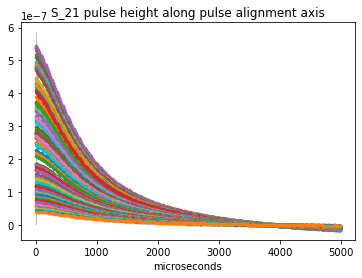

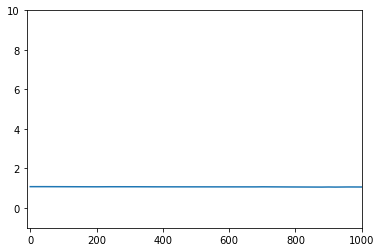

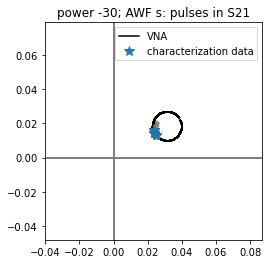

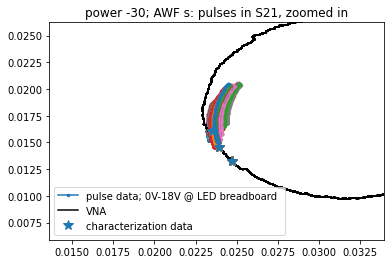

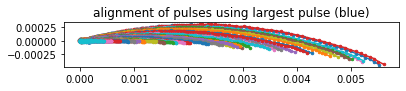

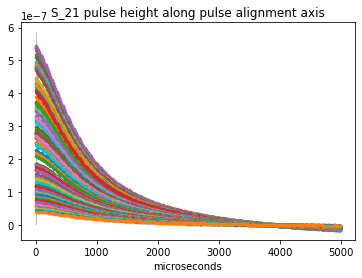

In [19]:
j = 0

last_width = 0.
time_window_range = fraction_to_keep * time_btw_pulse *1e6
time_window = np.arange(0,time_window_range,1/sampling_rate*1e6)
# time_window = np.arange(-200,time_window_range-200,1/sampling_rate*1e6)
# time_window = np.arange(window_shift_seconds*1e6,time_window_range+window_shift_seconds*1e6,1/sampling_rate*1e6)
for pulse_file in led_files[::-1]:
    print('===================')
    print('cleaning pulse file:',pulse_file)
    print('using VNA file:     ',vna_file)
    print('using summary file: ',sum_file)
    char_file = sum_file

    AWF_string = "10 us"
    title_1 = 'power ' + str(rf_power) + '; AWF ' + AWF_string[4:] + ': pulses in S21'
    title_1p5 = 'power ' + str(rf_power) + '; AWF ' + AWF_string[4] + ': pulses in S21, zoomed in'
    title_1p75 = 'alignment of pulses using largest pulse (blue)'
    # title_2 = 'power ' + power_directories[j][:-1] + ': timestream along rotated axis'    
    title_2 = 'S_21 pulse height along pulse alignment axis'
    clean_pulse_file = pulse_file[:-3] + '_cleaned.h5'
    with h5py.File(clean_pulse_file, "r") as fyle:
        pulse_avg = np.array(fyle["pulse_shape"],dtype=np.complex128)
        pulse_timestream = np.array(fyle["cleaned_data"],dtype=np.complex128)
#     with h5py.File(char_file,'r') as fyle:
#         char_points = np.array(fyle['means'])
#         char_f = np.array(fyle['frequencies'])
#         readout_f = char_f[0]
    readout_f = charFs[1]
    f,z = PUf.read_vna(vna_file)

    # print(pulse_fs)
    df_f, d1_Q, _, _ = Prf.resonator_basis(pulse_avg,readout_f*1e-3,f*1e-3,z,charFs*1e-3,charZs)#,plot_title='power ' + power_directories[j][:-1] + ' AWF ' + AWF_string)
    df_f_timestream, d1_Q_timestream, _, _ = Prf.resonator_basis(pulse_timestream[:,0],readout_f*1e-3,f*1e-3,z,charFs*1e-3,charZs)
    # plt.axis([0.058, 0.062, -0.19, -0.15])

    pulse_avg_mb = pulse_avg - np.mean(pulse_avg[-5:],dtype=np.complex128)
    if j == 0:
        std = np.std(abs(pulse_avg_mb[-5:]),dtype=np.complex128)
        # average_angle = np.mean(np.angle(pulse_avg_mb[abs(pulse_avg_mb) > 5*std]))
        # average_angle = np.mean(np.angle(pulse_avg_mb[abs(pulse_avg_mb[time_window > 200]) > 5*std]))
        average_angle = np.mean(np.angle(pulse_avg_mb[np.logical_and(time_window>200,time_window<300)]))
    pulse_timestream_mb = pulse_timestream[:,0] - np.mean(pulse_avg[-5:],dtype=np.complex128)

    pulse_avg_rotated = pulse_avg_mb * np.exp(-1j*average_angle)
    pulse_timestream_rotated = pulse_timestream_mb * np.exp(-1j*average_angle)

    template = df_f - np.mean(df_f[-100:])
    noise = df_f_timestream - np.mean(df_f[-100:])

#     template = pulse_avg_rotated.real #pulse_avg_rotated.real
#     noise = pulse_timestream_rotated.real
#     print(np.shape(pulse_avg),np.shape(df_f))

    with h5py.File(clean_pulse_file, "a") as fyle:
        print("Saving clean pulse file:",clean_pulse_file)
        if 'df_f_template' in fyle.keys():
            del fyle['df_f_template']
        if 'df_f_pulse_noise' in fyle.keys():
            del fyle['df_f_pulse_noise']
        fyle.create_dataset('df_f_template',data = np.asarray(template))
        fyle.create_dataset('df_f_pulse_noise',data = np.asarray(noise))
    if i % 1 == 0:
        label_c = 'characterization data' if i == 0 else None
        label_V = 'VNA' if i == 0 else None
        label_p = 'pulse data; 0V-18V @ LED breadboard ' if i == 0 else None
        plt.figure(title_1)
        plt.plot(pulse_avg.real,pulse_avg.imag,ls='-',marker='.',markersize=5,color='C'+str(i%10))
        plt.plot(z.real,z.imag,color='k',label=label_V)
        plt.plot(charZs.real,charZs.imag,marker='*',markersize=10,ls='',label=label_c,zorder=-5*i+200)
        plt.axhline(0,color='grey')
        plt.axvline(0,color='grey')
        plt.title(title_1)
        width = 8e3 * np.std(pulse_avg.real)
        x_c = np.mean(pulse_avg.real)
        y_c = np.mean(pulse_avg.imag)
        plt.axis([x_c - width/2., x_c + width/2., y_c-width/2., y_c+width/2.])
        ax = plt.gca()
        ax.set_aspect('equal','box')
        plt.legend()

        plt.figure(title_1p5)
        plt.plot(pulse_avg.real,pulse_avg.imag,ls='-',marker='.',markersize=5,color='C'+str(i%10),label=label_p,zorder=-5*i+200)
        plt.plot(z.real,z.imag,color='k',label=label_V)
        plt.plot(charZs.real,charZs.imag,marker='*',markersize=10,ls='',label=label_c,zorder=-5*i+200)
        plt.title(title_1p5)

        if i == 0:
            width = 150 * np.std(pulse_avg.real)
            x_c = np.mean(pulse_avg.real)
            y_c = np.mean(pulse_avg.imag)
            plt.axis([x_c - width/2., x_c + width/2., y_c-width/2., y_c+width/2.])
            plt.legend()
        # plt.axis([0.055,0.06,-0.175,-0.17])
        # plt.axis([-0.025,-0.023,-0.031,-0.029])
        # plt.savefig('power_' + power_directories[j][:-1] + '_AWF_' + NDF_directories[i][:-1] + '_S21_100mK.png')

        if i % 3 == 0:
            plt.figure(title_1p75)
            plt.plot(pulse_avg_rotated.real,pulse_avg_rotated.imag,ls='-',marker='.',markersize=5,color='C'+str(i%10))
            ax = plt.gca()
            ax.set_aspect('equal', 'box')
            plt.title(title_1p75)



    AWF_idx = AWF_string.find('us')
    width = float(AWF_string[AWF_idx-3:AWF_idx])
    plt.figure(title_2)
    radius, arc_length, _, _ = Prf.electronics_basis(pulse_avg)
    # pulse_avg_plot = arc_length
    # pulse_avg_plot = pulse_avg.imag - np.mean(pulse_avg[:20].imag)
    pulse_avg_plot = template

    plt.plot(time_window,pulse_avg_plot,ls='-',marker='.',markersize=5,color='C'+str(i))
    # print((100+last_width,-4e-7),current_width-last_width)
    if i == 0:
        plot_max = max(pulse_avg_plot)
        ax = plt.gca()
        ax.add_patch(mpatches.Rectangle((0,0),width,plot_max*1.1,alpha=0.4,color='C'+str(i)))
#     plt.xlim([window_shift_seconds-10, 1000])
    plt.xlabel('microseconds')
    plt.title(title_2)
    # plt.ylim([-4e-7,4e-7])

    if i == 0:
        stored_pulse = pulse_avg_rotated.real
    elif i == 8:
        current_pulse = pulse_avg_rotated.real
        ratio = stored_pulse / current_pulse
        plt.figure('ratio of pulses')
        plt.plot(time_window,ratio)
        plt.xlim([-10, 1000])
        plt.ylim([-1,10])


    # plt.savefig('power_' + power_directories[j][:-1] + '_d1_Q_100mK.png')
    i += 1
j += 1
    
directory = "/data/ProcessedOutputs/out"+series
plt.figure(title_1)
# plt.savefig(directory + 'VNA_char_pulse_S21.png',dpi=300,facecolor='white',transparent=False)
plt.figure(title_1p5)
# plt.savefig(directory + 'VNA_char_pulse_S21_zoomed_in.png',dpi=300,facecolor='white',transparent=False)
plt.figure(title_1p75)
# plt.savefig(directory + 'pulse_alignment.png',dpi=300,facecolor='white',transparent=False)
plt.figure(title_2)
# plt.savefig(directory +'timestream_aligned',dpi=300,facecolor='white',transparent=False)

## Optimal Filter code

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`
power: -30
Clean pulse file w/ template: /data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_4.820V_20221031_093936_cleaned.h5
0.005
mu = 1.01e+00; sigma = 3.49e-02; sigma_0 = 1.911e-02
mu = 1.02e+00; sigma = 3.38e-02; sigma_0 = 1.911e-02
/data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_4.800V_20221031_093936.h5
mu = 9.77e-01; sigma = 4.41e-02; sigma_0 = 1.911e-02
mu = 1.02e+00; sigma = 3.01e-02; sigma_0 = 1.911e-02
mu = 1.03e+00; sigma = 2.74e-02; sigma_0 = 1.911e-02
mu = 9.66e-01; sigma = 3.18e-02; sigma_0 = 1.911e-02
mu = 9.30e-01; sigma = 3.19e-02; sigma_0 = 1.911e-02
mu = 9.08e-01; sigma = 3.26e-02; sigma_0 = 1.911e-02
mu = 9.03e-01; sigma = 4.24e-02; sigma_0 = 1.911e-02
mu = 9.35e-01; sigma = 2.65e-02; sigma_0 = 1.911e-02
mu = 9.02e-01; sigma = 4.17e-02; sigma_0 = 1.911e-02
mu = 9.18e-01; sigma = 4.70e-02; sigma_0 = 1.911e-02
/data/USRP_Laser_Data/20221031/20221031_093936/USRP_LaserOn_4.600V_20221031_093936.h5
mu = 9.08e-01; s

<ipython-input-33-1105466a1bda>:295: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(b7_res**2 + (mu)*r)
/usr/local/share/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


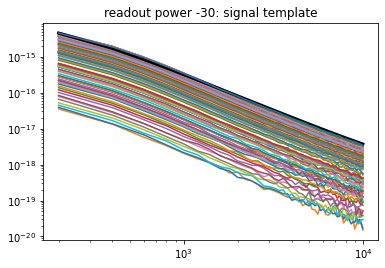

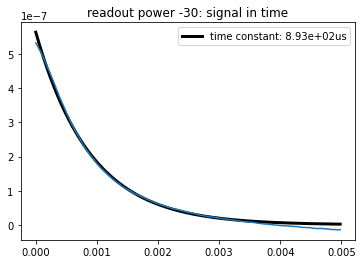

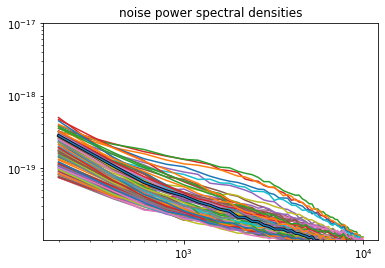

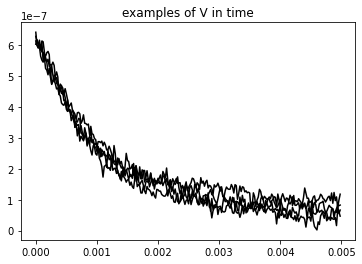

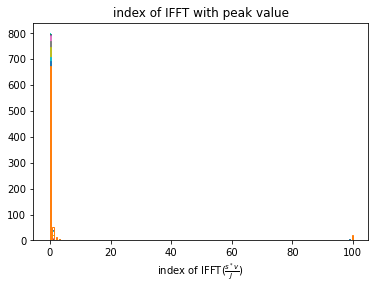

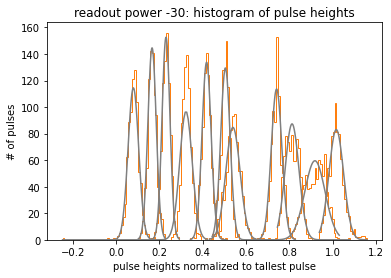

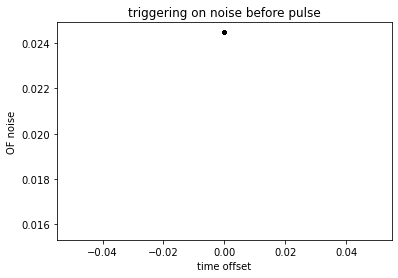

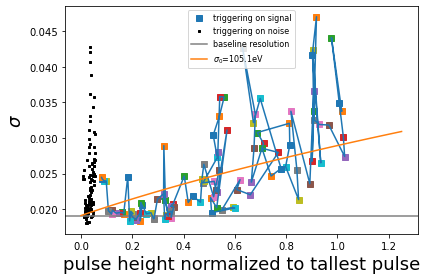

In [33]:
%matplotlib inline
# from statistics import mode
# import scipy
# import numpy.fft as fft
# reload(Prf)
i = 0
verbose = False
# for NDF_pulse_files,NDF_pulse_vna_file in zip(power_NDF_pulse_files,power_NDF_pulse_vna_files):
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`')
#     print(power_directories,i)
print('power:',rf_power)

title_1 = 'readout power ' + str(rf_power) + ': signal template'
title_1p5 = 'readout power ' + str(rf_power) + ': signal in time'
title_2 = 'readout power ' + str(rf_power) + ': noise power spectral density'
title_2 = 'noise power spectral densities'
title_2p1 = 'examples of V in time'
title_2p25  = 'convolution'
title_2p5 = 'index of IFFT with peak value'
title_3 = 'readout power ' + str(rf_power) + ': histogram of pulse heights'
title_4 = 'readout power ' + str(rf_power) + ': sigma vs mu'

clean_pulse_file = led_files[-1][:-3] + '_cleaned.h5'
print("Clean pulse file w/ template:",clean_pulse_file)
with h5py.File(clean_pulse_file, "r") as fyle:
    N = len(np.array(fyle["df_f_template"]))
    sampling_rate = np.array(fyle['sampling_rate'])

T = N/sampling_rate
time, f = Prf.build_t_and_f(N,sampling_rate)

f_max = 1e4
f_mask = np.logical_and(f <= f_max, f >= -1*f_max)
N_mask = len(f[f_mask])
f_plot = np.logical_and(f > 0, f <= f_max)
new_fs = max(f[f_mask])

offset_exponent = np.zeros((N_mask,N_mask),dtype=np.complex128)
time_ds = np.linspace(0,(N_mask-2)/(2*new_fs),N_mask)
print((N_mask-1)/(2*new_fs))
for j in range(N_mask):
    offset_exponent[j,:] = np.exp(1j*2*np.pi*f[f_mask][j]*time_ds)

for j in range(N_mask):
    for k in range(N_mask):
        if abs(offset_exponent[j,k].real) < 1e-10:
            offset_exponent[j,k] = 1j*offset_exponent[j,k].imag
        if abs(offset_exponent[j,k].imag) < 1e-10:
            offset_exponent[j,k] = offset_exponent[j,k].real

mu = np.zeros(N_mask)
sigma = np.zeros(N_mask)
j = 0
s_found = False

mus = []
sigmas = []

for pulse_file in led_files[::-1]:
    if verbose: 
        print('=====================')
        print('analyzing data file: ' + pulse_file)
    color = 'C'+str(j%10)
#         print(pulse_file)
    clean_pulse_file = pulse_file[:-3] + '_cleaned.h5'
    with h5py.File(clean_pulse_file, "r") as fyle:
        pulse_avg = np.array(fyle["df_f_template"])            
        pulse_noise = np.array(fyle["df_f_pulse_noise"])

#     pulse_avg = np.polyval(dtheta_to_energy_fit,pulse_avg)
#     pulse_noise = np.polyval(dtheta_to_energy_fit,pulse_noise)
    t_offset = lambda N: 0 #N//2
    # t_offset = lambda N: 0
    pulse_recentered = np.concatenate((pulse_avg[t_offset(N):],pulse_avg[:t_offset(N)]))
    # pulse_recentered = np.concatenate(np.zeros())
    w = scipy.signal.blackman(N_mask)
    exponential = lambda x, A, tau: np.heaviside(x-time[t_offset(N)],1) * A * np.exp(-1*(x-time[t_offset(N)])/tau)
    # exponential = lambda x, A, tau_qp: A * np.exp(-1*x/tau)
    popt,_ = opt.curve_fit(exponential,time,pulse_recentered,[1.2e-4,50e-6])
    pulse_fit = exponential(time,*popt)
    s_temp = Prf.discrete_FT(pulse_recentered)
    if j == 0:
        A = np.trapz(pulse_fit,dx = time[1]-time[0])
        # s = Prf.discrete_FT(pulse_fit/A)
        # s = fft.ifft(pulse_recentered) / max(pulse_recentered)
        s = Prf.discrete_FT(pulse_fit)#/max(pulse_recentered))
    # if j <= len(NDF_pulse_files)-5:
        plt.figure(title_1)
        S_mag = abs(s[f_mask]**2)
        plt.plot(f[f_plot],abs(s[f_plot]**2),zorder=-5*j+5,color='k',linewidth=3)
        plt.figure(title_1p5)
        plt.plot(time,pulse_fit,'k',linewidth=3,label='time constant: {:.2e}us'.format(popt[1]*1e6) )
        plt.plot(time,pulse_recentered)
        plt.legend()
    plt.figure(title_1)
    plt.plot(f[f_plot],abs(s_temp[f_plot]**2),zorder=-5*j+5,color=color)

#     pulse_filter = pulse_avg[::-1]/max(pulse_avg)
#     plt.figure(10)
#     plt.plot(pulse_filter,zorder=100-5*i)
#     filtered_data = scipy.signal.fftconvolve(pulse_noise, pulse_filter, mode="valid")

#     time = np.linspace(0,len(filtered_data)/sampling_rate,len(filtered_data))
#     print(time,filtered_data)
#     plt.figure(1)
#     plt.plot(time,filtered_data)
#     plt.xlim([4.005,4.010])

    samples_per_pulse = sampling_rate*time_btw_pulse
    window_shift_J = -10e-6
    window_shift_J_idx = int(window_shift_J*sampling_rate)
    J_temp = np.zeros(N)
    # for pulse_i in range(num_pulses):
    for pulse_i in range(pulse_start,int(total_pulses),1):                
        pulse_i_end = int((pulse_i+1)*samples_per_pulse) 
        no_pulse_idx_start = pulse_i_end - N + window_shift_J_idx
        no_pulse_idx_end = pulse_i_end + window_shift_J_idx
        no_pulse_idx_list = np.arange(no_pulse_idx_start,no_pulse_idx_end,1,dtype=int)
        no_pulse_noise_i = pulse_noise[no_pulse_idx_list]
        # if pulse_i == 0:
        #     print(time[no_pulse_idx_start])

        J_temp += abs(Prf.discrete_FT(no_pulse_noise_i))**2 / num_pulses * 2 * T
        # J_temp += abs(fft.ifft(no_pulse_noise_i))**2 / num_pulses * 2 * T

    if j == 0:
        J = J_temp
        plt.figure(title_2)
        plt.plot(f[f_plot],J[f_plot],zorder=-5*j+5,color='k',linewidth=3)
    else:
        plt.figure(title_2)
        plt.plot(f[f_plot],J_temp[f_plot],zorder=-5*j+5,color=color)


    plt.figure(title_2)
    plt.plot(f[f_plot],J[f_plot],zorder=-5*j+5,color=color)
    denominator = np.sum(abs(s[f_mask])**2/J[f_mask])


    A_hat = np.zeros((num_pulses,N_mask))
    A_max_idx = np.zeros(num_pulses)
    A_hat_max = np.zeros(num_pulses)
    A_hat_sum = np.zeros(num_pulses)
    # numerator_sum = np.zeros(N_mask)

    b7_res = np.sqrt(((2*T*denominator)**-1))
    k = 0
    t_offset_idx = t_offset(N_mask)
    for pulse_i in range(pulse_start,int(total_pulses),1):
        pulse_i_start = int(pulse_i*samples_per_pulse)
        pulse_idx_start = pulse_i_start + window_shift
        pulse_idx_end = pulse_idx_start + N
        pulse_idx_list = np.arange(pulse_idx_start,pulse_idx_end,1,dtype=int)
        pulse_noise_i = pulse_noise[pulse_idx_list]
        # pulse_noise_i_recentered = np.concatenate((pulse_noise_i[N//2:],pulse_noise_i[:N//2]))

        v = Prf.discrete_FT(pulse_noise_i - np.mean(pulse_noise_i[-5:])) 
        # v_ps = abs(v)**2 
        # v_ps = v[f_plot]
        # v = fft.fft(pulse_noise_i - np.mean(pulse_noise_i[-5:])) / N_mask


        pulse_i_end = int((pulse_i+1)*samples_per_pulse) 
        no_pulse_idx_start = pulse_i_end - N + window_shift_J_idx
        no_pulse_idx_end = pulse_i_end + window_shift_J_idx
        no_pulse_idx_list = np.arange(no_pulse_idx_start,no_pulse_idx_end,1,dtype=int)
        no_pulse_noise_i = pulse_noise[no_pulse_idx_list]
        v_temp = Prf.discrete_FT(no_pulse_noise_i)


        if j == 0 and (pulse_i + 2) % 200 == 0:
            plt.figure(title_2p1)
            # plt.plot(time,no_pulse_noise_i,color='grey')
            plt.plot(time,pulse_noise_i,color='k')

        numerator = Prf.discrete_IFT(np.conj(s[f_mask])*v[f_mask]/J[f_mask])
        numerator = numerator.real

        numerator_sum = sum(offset_exponent[:,t_offset_idx]*np.conj(s[f_mask])*v_temp[f_mask]/J[f_mask])
        numerator_sum = numerator_sum.real
        # if pulse_i % 100 == 0: 
        #     print(numerator_sum)
#             if pulse_i % 50 == 0:
#                 idx_range = 20
#                 plt.plot(np.arange(-idx_range,0,1),numerator[-idx_range:]/denominator,ls='',marker='.',color=color)
#                 plt.plot(np.arange(0,idx_range,1),numerator[:idx_range]/denominator,ls='',marker='.',color=color)

        max_numerator = max(numerator)
        max_idx = np.argwhere(numerator == max_numerator)

        A_max_idx[k] = max_idx 
        A_hat[k,:] = numerator / denominator

        A_hat_max[k] = max_numerator/denominator

        A_hat_sum[k] = numerator_sum / denominator
        k += 1


    for k in range(N_mask):
        (mu[k], sigma[k]) = scipy.stats.norm.fit(A_hat[:,k])
    # optimal_t0 = t_offset(N_mask)
    if j == 0:
        # optimal_t0 = int(mode(A_max_idx))
        optimal_t0 = t_offset_idx
    (mu_max, sigma_max) = scipy.stats.norm.fit(A_hat_max)
    (mu_sum, sigma_sum) = scipy.stats.norm.fit(A_hat_sum)
    print('mu = ' + "{:.2e}".format(mu[t_offset_idx]) + '; sigma = ' + "{:.2e}".format(sigma[t_offset_idx])+ '; sigma_0 = ' + "{:.3e}".format(b7_res))
#         try:            
    if not 'no NDF' in pulse_file:
        plt.figure(title_2p5)
        n, bins, patches = plt.hist(A_max_idx,bins=N,fill=False,histtype='step',label='radians',color=color)
        if (j+0) % 1 == 0:
            plt.figure(title_3)
            print(led_files[::-1][j])
            if j == 0:
                n, bins, patches = plt.hist(A_hat[:,optimal_t0],bins=25,fill=False,histtype='step',label='radians',color=color)
                bin_width = bins[1]-bins[0]
            else:
                data = A_hat[:,optimal_t0]
                n, bins, patches = plt.hist(data,bins=np.arange(min(data), max(data) + bin_width, bin_width),fill=False,histtype='step',label='radians',color=color)
            plt.plot(np.linspace(bins[0],bins[-1],100),\
                     len(A_hat)*(bins[1]-bins[0])*scipy.stats.norm.pdf(np.linspace(bins[0],bins[-1],100),mu[optimal_t0],sigma[optimal_t0]),\
                     c='gray')

        # mu2s.append(mu2); sigma2s.append(sigma2)
        mus.append(mu[optimal_t0]); sigmas.append(sigma[optimal_t0])

        plt.figure(title_4)
        if j == 0:
            label1 = 'triggering on signal'
            label2 = 'triggering on noise'
        else:
            label1 = None
            label2 = None
        plt.plot(mu[optimal_t0],sigma[optimal_t0],color=color,ls='',marker='s',label=label1)
        plt.plot(mu_sum,sigma_sum,ls='',marker='s',color='k',markersize=2,label=label2)
        # plt.plot(mu2,sigma2,color=color,ls='',marker='x')
        # plt.plot(mu_sum,sigma_sum,color='k',ls='',marker='s',markersize=2)


#         except:
#             pass
    j += 1

plt.figure(title_1)
ax = plt.gca(); ax.set_yscale('log'); ax.set_xscale('log')
plt.title(title_1)

plt.figure(title_1p5)
plt.title(title_1p5)

plt.figure(title_2)
ax = plt.gca(); ax.set_yscale('log'); ax.set_xscale('log')
J_avg = np.mean(J)
plt.ylim([1e-1*J_avg,1e2*J_avg])
plt.title(title_2)

plt.figure(title_2p1)
plt.title(title_2p1)

plt.figure(title_2p5)
plt.title(title_2p5)
plt.xlabel(r'index of IFFT($\frac{s^*v}{J}$)')

plt.figure(title_3)
plt.title(title_3)
plt.xlabel('pulse heights normalized to tallest pulse')
plt.ylabel('# of pulses')
#     plt.xlim([-0.25,0.5])
# ax = plt.gca(); ax.set_yscale('log');
# plt.ylim([10**-1,10**3])

plt.figure(title_4)
#     plt.title(title_4)
plt.axhline(b7_res,color='grey',label='baseline resolution')
plt.xlabel('pulse height normalized to tallest pulse',fontsize=18)
plt.ylabel('$\sigma$',fontsize=18)
plt.legend()
# plt.ylim([0.2,0.5])

plt.figure()
print(sigma.shape)
for j in range(N_mask):
    plt.plot(np.mean(sigma,axis=0))
    plt.plot(optimal_t0,np.mean(sigma[optimal_t0]),ls='',marker='.',color='k')
# print(np.mean(np.mean(sigma[-8:])))
plt.xlabel('time offset')
plt.ylabel('OF noise')
plt.title('triggering on noise before pulse')
# plt.savefig('triggering_on_noise_after_pulse',dpi=300,facecolor='white',transparent=False)

def sig(mu,sigma_0,r):
#     return np.sqrt(sigma_0**2 + (mu)*r)
    return np.sqrt(b7_res**2 + (mu)*r)

def sig2(mu,r):
    return np.sqrt(b7_res**2 + (mu)*r)


mus = np.array(mus)
sigmas = np.array(sigmas)

# import scipy
p0 = [1e-1,1e-2]
# f_fit_vals,_ = scipy.optimize.curve_fit(f,mu,sigma,p0,bounds=[(15*(0.008/2.6),7e-3),(40*(0.008/2.6),0.1)])
f_fit_vals,_ = scipy.optimize.curve_fit(sig,mus[sigmas<0.035],sigmas[sigmas<0.035],p0)
# f_fit_vals,_ = scipy.optimize.curve_fit(sig,mus,sigmas,p0)
print(np.max(sigma))
# f_fit_vals,_ = scipy.optimize.curve_fit(sig2,mu,[p0[1]])

# sigma_0_E_pub = abs(f_fit_vals[0])/(f_fit_vals[1]/2.6)
sigma_0_E_pub = abs(b7_res)/(f_fit_vals[1]/2.6)
# r_E = f_fit_vals[0]/2.6
r_E = f_fit_vals[1]/2.6
print(r_E)
print('energy resolution estimate is: ' + str(sigma_0_E_pub))

mu_plot = np.linspace(0,1.25,100)
plt.figure(title_4)
plt.plot(mus,np.array(sigmas))
plt.plot(mu_plot,sig(mu_plot,*f_fit_vals),label='$\sigma_0$='+str(round(sigma_0_E_pub,1))+'eV')
# plt.plot(mu_plot,sig2(mu_plot,*f_fit_vals),label='$\sigma_0$='+str(round(sigma_0_E_pub,1))+'eV')
# custom_lines = [\
#             #Line2D([0], [0],color='k',ls='',marker='.',label='max of IFT'),\
#             #Line2D([0], [0], color='k',alpha=0.5, ls='dashdot',label='radius and arc length directions'),\
#             Line2D([0], [0],color='k',ls='',marker='s',label='index 0'),]
#             #Line2D([0], [0], ls='',color='C1', marker='.',label='off resonance timestream')]
# #     plt.legend(handles=custom_lines)
plt.legend(loc='best',fontsize=8)
# plt.ylim([0,0.05])
plt.tight_layout()
plt.savefig('sigma_vs_mu.png',dpi=200)
i += 1

In [ ]:
print(105.3/(1/r_E))
## To clean up 
'''
- Why are there points that shoot up in sigma -- remove the regions of timestreams that have non-LED pulses
    - Trigger on full timestream, check separation between pulses and if it doesnt line up cut the pulses
- 
'''

In [ ]:
## Estimate eta_ph
100.0*(60.0/2104.)

In [ ]:
import MB_equations as MBe
k2 = MBe.kappa_2(12.0e-3, 4.24205e9, 1.8e-4)

In [ ]:
print(k2)

In [ ]:
M = 1
V = 3e4
hv = 2.64
a = 3.7/100.
D = 1.8e-4
k2 = 4e-7

fac = (a * k2 * hv) / (2 * M * V * D)
print(fac)

In [ ]:
sig = 105.3
N = 1e22
print(sig/fac)

In [ ]:
eta_ph = 100.0 * (sig / fac / np.sqrt(N))

In [ ]:
print(eta_ph)